In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [345]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [346]:
df.set_index('Date', inplace=True)

In [347]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [348]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(4720, 20, 4)

In [349]:
v = X.reshape(X.shape[0],20, 4)
v[0]

array([[1.        , 1.        , 1.        , 1.        ],
       [0.7777777 , 0.94479144, 0.78688532, 0.83557722],
       [0.6666669 , 0.87776276, 0.80767705, 0.76058483],
       [0.51851894, 0.79396114, 0.17798754, 0.59494365],
       [0.5555554 , 0.72982324, 0.23887645, 0.69826378],
       [0.62962973, 0.68909529, 0.36065658, 0.75826988],
       [0.74074053, 0.67494693, 0.5658775 , 0.86506244],
       [0.5555554 , 0.62911891, 0.25015238, 0.7693573 ],
       [0.51851894, 0.58357019, 0.20721488, 0.71489491],
       [0.59259257, 0.55857142, 0.34360739, 0.75826988],
       [0.40740743, 0.50356228, 0.07081977, 0.62966799],
       [0.4444446 , 0.46378738, 0.20362391, 0.65854401],
       [0.2222223 , 0.38950406, 0.0085543 , 0.53000305],
       [0.14814867, 0.31310649, 0.12386306, 0.34133415],
       [0.07407434, 0.23491981, 0.06557514, 0.19043558],
       [0.03703717, 0.16199056, 0.00262417, 0.04843131],
       [0.14814867, 0.12059507, 0.26229594, 0.10886384],
       [0.        , 0.05848294,

In [350]:
y = labels
y = np.array(y)
y.shape

(4720,)

In [351]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [352]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [353]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [354]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [355]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [356]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2947 - accuracy: 0.5193 - mse: 0.4515 - weighted_accuracy: 0.3278 - weighted_mse: 0.5263 - val_loss: 0.2992 - val_accuracy: 0.0456 - val_mse: 0.3563 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3563
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2120 - accuracy: 0.3700 - mse: 0.7932 - weighted_accuracy: 0.4063 - weighted_mse: 0.7713 - val_loss: 0.2903 - val_accuracy: 0.0456 - val_mse: 0.3869 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3869
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1924 - accuracy: 0.3223 - mse: 1.0299 - weighted_accuracy: 0.4478 - weighted_mse: 0.9936 - val_loss: 0.2810 - val_accuracy: 0.0456 - val_mse: 0.4265 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.4265
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1838 - accuracy: 0.3085 - mse: 1.1644 - weighted_accuracy: 0.4910 - weighte

30/30 [==============================] - 0s 8ms/step - loss: 0.1421 - accuracy: 0.3933 - mse: 1.5856 - weighted_accuracy: 0.6851 - weighted_mse: 1.5021 - val_loss: 0.1908 - val_accuracy: 0.3538 - val_mse: 1.6481 - val_weighted_accuracy: 0.3538 - val_weighted_mse: 1.6481
Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1405 - accuracy: 0.4055 - mse: 1.5725 - weighted_accuracy: 0.7062 - weighted_mse: 1.4983 - val_loss: 0.1927 - val_accuracy: 0.3602 - val_mse: 1.5995 - val_weighted_accuracy: 0.3602 - val_weighted_mse: 1.5995
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1397 - accuracy: 0.3845 - mse: 1.5905 - weighted_accuracy: 0.7116 - weighted_mse: 1.5082 - val_loss: 0.1868 - val_accuracy: 0.4131 - val_mse: 1.6030 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.6030
Epoch 32/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1391 - accuracy: 0.4306 - mse: 1.5951 - weighted_accuracy: 0.7173 - weighted_mse: 1.5

Epoch 58/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1171 - accuracy: 0.5511 - mse: 1.9874 - weighted_accuracy: 0.7875 - weighted_mse: 1.9477 - val_loss: 0.1815 - val_accuracy: 0.4841 - val_mse: 2.1015 - val_weighted_accuracy: 0.4841 - val_weighted_mse: 2.1015
Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.5609 - mse: 2.0264 - weighted_accuracy: 0.7873 - weighted_mse: 1.9931 - val_loss: 0.1813 - val_accuracy: 0.4820 - val_mse: 2.2570 - val_weighted_accuracy: 0.4820 - val_weighted_mse: 2.2570
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1148 - accuracy: 0.5389 - mse: 2.0147 - weighted_accuracy: 0.7904 - weighted_mse: 1.9731 - val_loss: 0.1942 - val_accuracy: 0.4417 - val_mse: 2.1364 - val_weighted_accuracy: 0.4417 - val_weighted_mse: 2.1364
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1157 - accuracy: 0.5678 - mse: 2.0584 - weighted_accuracy: 0.7954 - weig

Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0925 - accuracy: 0.6639 - mse: 2.6068 - weighted_accuracy: 0.8583 - weighted_mse: 2.6208 - val_loss: 0.1565 - val_accuracy: 0.6250 - val_mse: 2.8048 - val_weighted_accuracy: 0.6250 - val_weighted_mse: 2.8048
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.6933 - mse: 2.6732 - weighted_accuracy: 0.8635 - weighted_mse: 2.6955 - val_loss: 0.1780 - val_accuracy: 0.5900 - val_mse: 2.9948 - val_weighted_accuracy: 0.5900 - val_weighted_mse: 2.9948
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0921 - accuracy: 0.6867 - mse: 2.6503 - weighted_accuracy: 0.8722 - weighted_mse: 2.6491 - val_loss: 0.1698 - val_accuracy: 0.5826 - val_mse: 2.7883 - val_weighted_accuracy: 0.5826 - val_weighted_mse: 2.7883
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0906 - accuracy: 0.6819 - mse: 2.7010 - weighted_accuracy: 0.8649 - weig

Epoch 116/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0701 - accuracy: 0.7656 - mse: 3.6064 - weighted_accuracy: 0.9085 - weighted_mse: 3.5966 - val_loss: 0.1833 - val_accuracy: 0.6356 - val_mse: 3.8415 - val_weighted_accuracy: 0.6356 - val_weighted_mse: 3.8415
Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.7879 - mse: 3.6420 - weighted_accuracy: 0.9037 - weighted_mse: 3.6319 - val_loss: 0.1961 - val_accuracy: 0.6229 - val_mse: 3.9668 - val_weighted_accuracy: 0.6229 - val_weighted_mse: 3.9668
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0708 - accuracy: 0.7680 - mse: 3.6713 - weighted_accuracy: 0.9057 - weighted_mse: 3.6930 - val_loss: 0.1772 - val_accuracy: 0.6600 - val_mse: 4.0172 - val_weighted_accuracy: 0.6600 - val_weighted_mse: 4.0172
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.7940 - mse: 3.7332 - weighted_accuracy: 0.9097 - 

Epoch 145/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0533 - accuracy: 0.8448 - mse: 5.0386 - weighted_accuracy: 0.9357 - weighted_mse: 4.8745 - val_loss: 0.1847 - val_accuracy: 0.7362 - val_mse: 5.7792 - val_weighted_accuracy: 0.7362 - val_weighted_mse: 5.7792
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0536 - accuracy: 0.8430 - mse: 5.1126 - weighted_accuracy: 0.9350 - weighted_mse: 4.9434 - val_loss: 0.2084 - val_accuracy: 0.6716 - val_mse: 5.1397 - val_weighted_accuracy: 0.6716 - val_weighted_mse: 5.1397
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.8538 - mse: 5.0519 - weighted_accuracy: 0.9390 - weighted_mse: 4.9213 - val_loss: 0.1920 - val_accuracy: 0.7203 - val_mse: 6.0972 - val_weighted_accuracy: 0.7203 - val_weighted_mse: 6.0972
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.8512 - mse: 5.2602 - weighted_accuracy: 0.9417 - 

Epoch 174/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0420 - accuracy: 0.8851 - mse: 6.6936 - weighted_accuracy: 0.9542 - weighted_mse: 6.3081 - val_loss: 0.2116 - val_accuracy: 0.7564 - val_mse: 7.5837 - val_weighted_accuracy: 0.7564 - val_weighted_mse: 7.5837
Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 0.8708 - mse: 6.7355 - weighted_accuracy: 0.9434 - weighted_mse: 6.3425 - val_loss: 0.2295 - val_accuracy: 0.6674 - val_mse: 6.7631 - val_weighted_accuracy: 0.6674 - val_weighted_mse: 6.7631
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8766 - mse: 6.7341 - weighted_accuracy: 0.9492 - weighted_mse: 6.3782 - val_loss: 0.2115 - val_accuracy: 0.7352 - val_mse: 7.3108 - val_weighted_accuracy: 0.7352 - val_weighted_mse: 7.3108
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.8761 - mse: 6.8004 - weighted_accuracy: 0.9472 - 

In [357]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2383449822664261
Test accuracy: 0.7521186470985413


In [358]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.6350394  -1.2708485  -0.84703267]
 [-2.6570938  -3.6664708   1.6697806 ]
 [-4.39278    -1.0334178   0.34151846]
 ...
 [-3.8919647  -5.158775    3.6467886 ]
 [-2.6743152  -5.154161    2.5501308 ]
 [-2.018856   -4.7859206   1.3926355 ]]


Counter({0: 56, 2: 793, 1: 95})

In [359]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 858, 0: 43, 1: 43})

In [360]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 944
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 42
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 42
actual holds but predicted buy: 93
actual holds but predicted sell: 56
actual predicted holds: 709
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 0.0%
Percentage holds correct: 82.63403263403264%
actual buys: 43
actual sells: 43
actual holds: 858


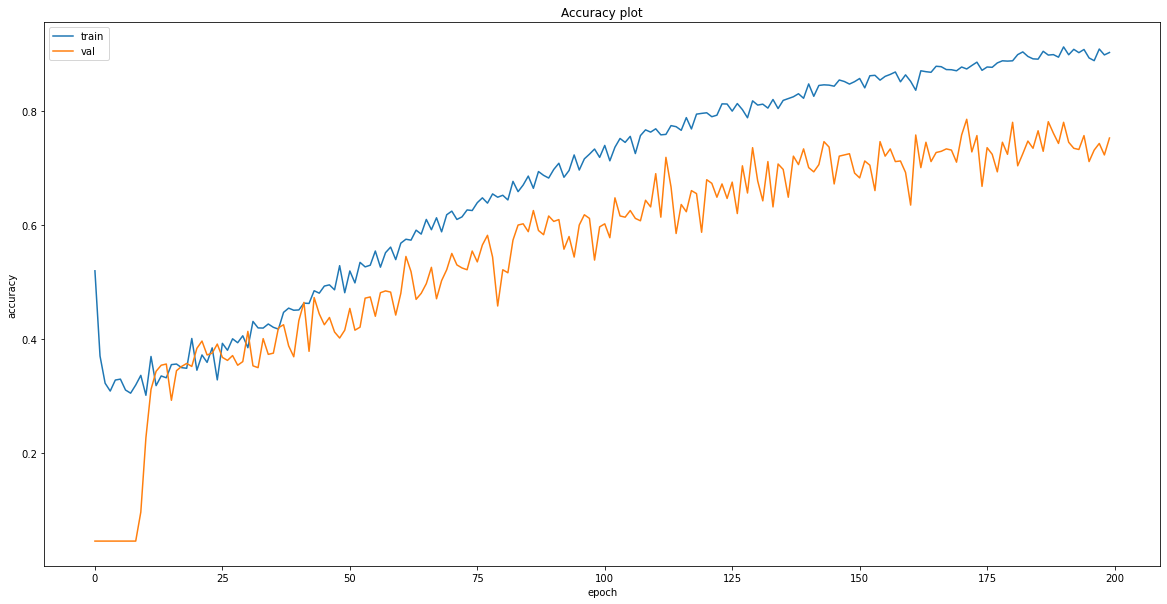

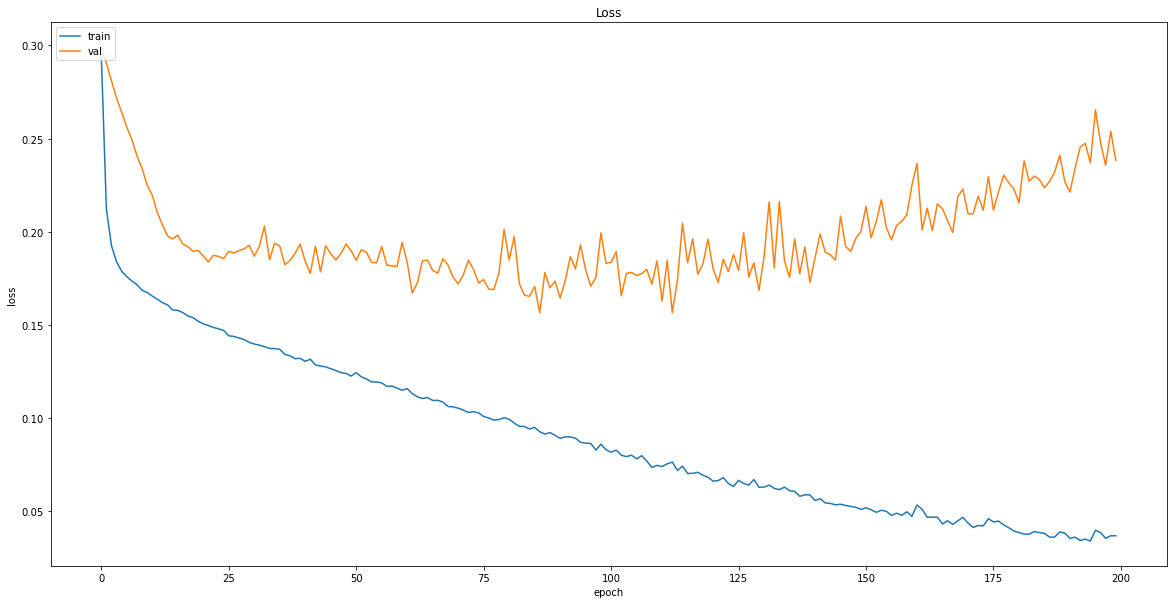

In [361]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [362]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [363]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-14,9.52,9.466080,-53.571343,-82078567.0,2.0
2018-12-17,9.33,9.445145,-87.500043,-84305791.0,2.0
2018-12-18,9.45,9.445892,-64.814890,-82764591.0,2.0
2018-12-19,9.39,9.437293,-75.925903,-84460291.0,2.0
2018-12-20,9.37,9.426940,-75.000054,-85913091.0,2.0


In [364]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [365]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [366]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [367]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1877 - accuracy: 0.7844 - mean_squared_error: 8.3780 - weighted_accuracy: 0.7844 - weighted_mean_squared_error: 8.3780
Test loss: 0.18772263824939728
Test accuracy: 0.7844036817550659


In [368]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 13, 2: 178, 1: 27})

In [369]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [370]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-370-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-370-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-370-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,0,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,0,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2
2019-02-15,9.76,9.706131,-6.250130,8384988.0,2.0,0,2


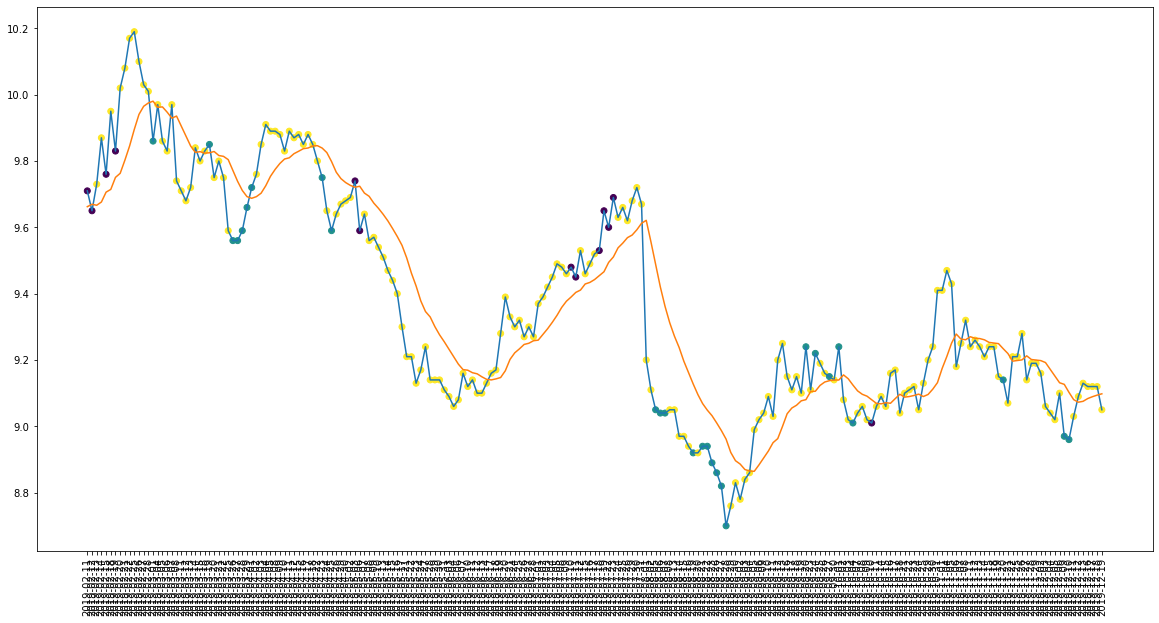

In [371]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [372]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 13
actual predicted holds: 166
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 0.0%
Percentage holds correct: 83.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [373]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 30.76923076923077%
Percentage holds correct: 83.61581920903954%


In [374]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 30.76923076923077%
Percentage holds correct: 83.61581920903954%


In [375]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.859999656677246
Shares owned at the moment: 1011
Cash capital at the moment: $4.1270830538269365


Stop Loss Activated!

Share price: $9.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9672.954639395952


Share price: $9.5600004196167
Shares owned at the moment: 1009
Cash capital at the moment: $0.38760483836995263


Stop Loss Activated!

Share price: $9.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9267.722195722818


Share price: $9.050000190734863
Shares owned at the moment: 1021
Cash capital at the moment: $2.261862946985275


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8860.534243742228


Share price: $8.699999809265138
Shares owned at the moment: 1015
Cash capital at the moment: $5.750562870500289




Capital at the end of test period: $9166.239943433997
profit gained: -8.337600565660033%


In [376]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [377]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-16,9.13,9.083831,-44.117515,-5009999.0,2.0
2019-12-17,9.12,9.089395,-43.750019,-5679099.0,2.0
2019-12-18,9.12,9.094104,-33.333333,-5679099.0,2.0
2019-12-19,9.12,9.098088,-33.333333,-5679099.0,2.0
2019-12-20,9.05,9.090690,-57.692110,-6968099.0,1.0


In [378]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [379]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(215, 20, 4)

In [380]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [381]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1976 - accuracy: 0.7860 - mean_squared_error: 8.9453 - weighted_accuracy: 0.7860 - weighted_mean_squared_error: 8.9453
Test loss: 0.1976473033428192
Test accuracy: 0.7860465049743652


In [382]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 1: 27, 0: 4})

In [383]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [384]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-384-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-384-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-384-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2
2020-02-18,8.51,8.626740,-32.258144,341600.0,2.0,2,2


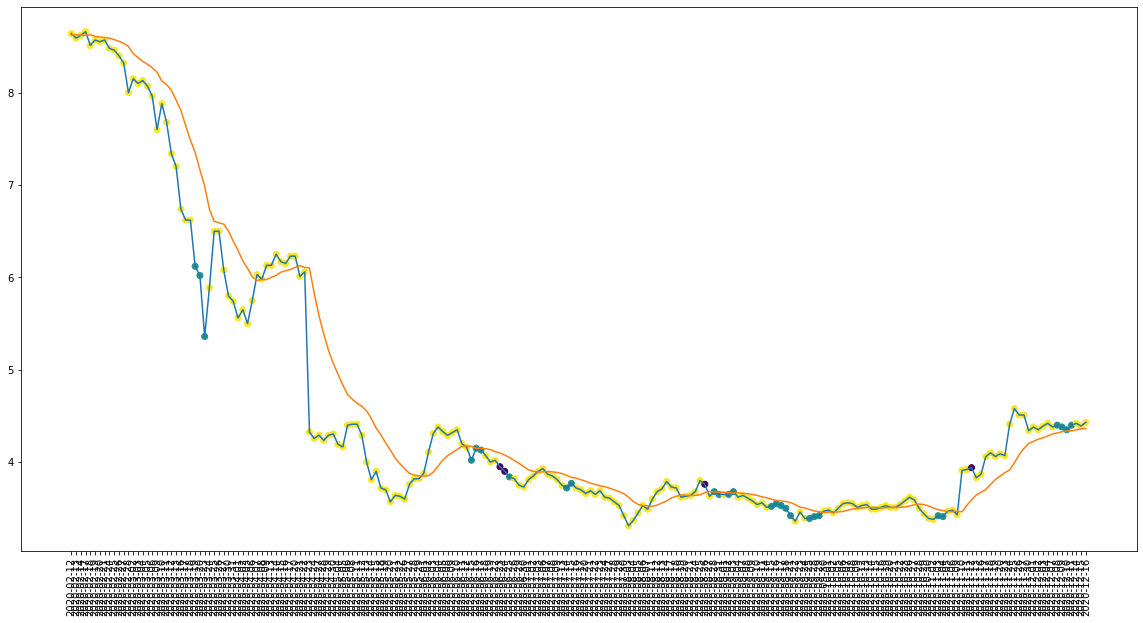

In [385]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [386]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 26
actual holds but predicted sell: 4
actual predicted holds: 168
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 84.84848484848484%
actual buys: 8
actual sells: 9
actual holds: 198


In [387]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 50.0%
Percentage holds correct: 84.69945355191257%


In [388]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $6.119999885559082
Shares owned at the moment: 1629
Cash capital at the moment: $3.104116936921855


Stop Loss Activated!

Share price: $5.360000133514403
Shares owned at the moment: 0
Cash capital at the moment: $8710.532873833774


Share price: $5.360000133514403
Shares owned at the moment: 1620
Cash capital at the moment: $3.4538569456344703


Stop Loss Activated!

Share price: $4.326051235198976
Shares owned at the moment: 0
Cash capital at the moment: $6992.384299715164


Share price: $4.019999980926514
Shares owned at the moment: 1734
Cash capital at the moment: $2.5349628795411263


Stop Loss Activated!

Share price: $3.9000000953674316
Shares owned at the moment: 0
Cash capital at the moment: $6746.537977791908


Share price: $3.839999914169312
Shares owned at the moment: 1752
Cash capital at the moment: $0.35700858080508624


Stop Loss Activated!

Share price: $3.7300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $6517.345901905657


Share 

In [389]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [300]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [301]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [302]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [303]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(4784, 20, 4)

In [304]:
y = labels
y = np.array(y)

In [305]:
X[0]

array([[0.62962983, 0.99321104, 0.11538448, 0.7145918 ],
       [0.70370387, 0.96240506, 0.25640994, 0.82446985],
       [0.62962983, 0.91293101, 0.16483514, 0.73398529],
       [0.592593  , 0.8593647 , 0.15384749, 0.64168773],
       [0.70370387, 0.84915046, 0.38461608, 0.69113284],
       [0.96296317, 0.92243375, 0.92307739, 0.88072739],
       [1.        , 0.99614635, 1.        , 1.        ],
       [0.8148151 , 1.        , 0.61538543, 0.83886386],
       [0.62962983, 0.94474212, 0.2307701 , 0.77271728],
       [0.70370387, 0.92139289, 0.38461608, 0.84380837],
       [0.5555558 , 0.85482097, 0.07692412, 0.71634985],
       [0.62962983, 0.82189833, 0.24725358, 0.75079661],
       [0.62962983, 0.79404071, 0.24725358, 0.75079661],
       [0.51851824, 0.73535754, 0.        , 0.62932645],
       [0.25925894, 0.60377644, 0.05244724, 0.45665312],
       [0.2222221 , 0.48073493, 0.17751463, 0.28859466],
       [0.11111087, 0.34151166, 0.08546999, 0.12938139],
       [0.2222221 , 0.25881858,

In [306]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [307]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [308]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [309]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [310]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2898 - accuracy: 0.5236 - mse: 0.4498 - weighted_accuracy: 0.3575 - weighted_mse: 0.5255 - val_loss: 0.2987 - val_accuracy: 0.0418 - val_mse: 0.3552 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3552
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2089 - accuracy: 0.3768 - mse: 0.7892 - weighted_accuracy: 0.4354 - weighted_mse: 0.7713 - val_loss: 0.2892 - val_accuracy: 0.0418 - val_mse: 0.3851 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3851
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1881 - accuracy: 0.3109 - mse: 1.0543 - weighted_accuracy: 0.4849 - weighted_mse: 1.0041 - val_loss: 0.2771 - val_accuracy: 0.0418 - val_mse: 0.4212 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4212
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.2995 - mse: 1.1779 - weighted_accuracy: 0.5102 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1342 - accuracy: 0.3878 - mse: 1.7741 - weighted_accuracy: 0.7167 - weighted_mse: 1.6764 - val_loss: 0.1695 - val_accuracy: 0.5089 - val_mse: 1.7978 - val_weighted_accuracy: 0.5089 - val_weighted_mse: 1.7978
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1340 - accuracy: 0.4155 - mse: 1.7747 - weighted_accuracy: 0.7242 - weighted_mse: 1.6952 - val_loss: 0.1962 - val_accuracy: 0.3448 - val_mse: 1.8805 - val_weighted_accuracy: 0.3448 - val_weighted_mse: 1.8805
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.4413 - mse: 1.7783 - weighted_accuracy: 0.7356 - weighted_mse: 1.6998 - val_loss: 0.1937 - val_accuracy: 0.3730 - val_mse: 1.7503 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 1.7503
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1313 - accuracy: 0.4586 - mse: 1.7811 - weighted_accuracy: 0.7329 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1070 - accuracy: 0.5811 - mse: 2.3606 - weighted_accuracy: 0.8045 - weighted_mse: 2.3203 - val_loss: 0.1845 - val_accuracy: 0.4953 - val_mse: 2.3922 - val_weighted_accuracy: 0.4953 - val_weighted_mse: 2.3922
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1066 - accuracy: 0.5856 - mse: 2.3834 - weighted_accuracy: 0.8203 - weighted_mse: 2.3551 - val_loss: 0.1882 - val_accuracy: 0.4848 - val_mse: 2.3923 - val_weighted_accuracy: 0.4848 - val_weighted_mse: 2.3923
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1069 - accuracy: 0.5767 - mse: 2.4265 - weighted_accuracy: 0.8147 - weighted_mse: 2.3910 - val_loss: 0.2309 - val_accuracy: 0.3908 - val_mse: 2.5928 - val_weighted_accuracy: 0.3908 - val_weighted_mse: 2.5928
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1054 - accuracy: 0.5743 - mse: 2.4653 - weighted_accuracy: 0.8148 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.6966 - mse: 3.3289 - weighted_accuracy: 0.8799 - weighted_mse: 3.2887 - val_loss: 0.1930 - val_accuracy: 0.5371 - val_mse: 3.4597 - val_weighted_accuracy: 0.5371 - val_weighted_mse: 3.4597
Epoch 89/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0849 - accuracy: 0.6985 - mse: 3.3319 - weighted_accuracy: 0.8785 - weighted_mse: 3.3110 - val_loss: 0.1768 - val_accuracy: 0.5967 - val_mse: 3.5452 - val_weighted_accuracy: 0.5967 - val_weighted_mse: 3.5452
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.6901 - mse: 3.4093 - weighted_accuracy: 0.8626 - weighted_mse: 3.3934 - val_loss: 0.1873 - val_accuracy: 0.5831 - val_mse: 3.4564 - val_weighted_accuracy: 0.5831 - val_weighted_mse: 3.4564
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.7100 - mse: 3.4879 - weighted_accuracy: 0.8659 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0656 - accuracy: 0.7891 - mse: 4.7867 - weighted_accuracy: 0.9080 - weighted_mse: 4.6099 - val_loss: 0.2538 - val_accuracy: 0.5590 - val_mse: 4.8346 - val_weighted_accuracy: 0.5590 - val_weighted_mse: 4.8346
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0670 - accuracy: 0.7703 - mse: 4.7543 - weighted_accuracy: 0.9029 - weighted_mse: 4.6109 - val_loss: 0.1744 - val_accuracy: 0.6970 - val_mse: 5.2063 - val_weighted_accuracy: 0.6970 - val_weighted_mse: 5.2063
Epoch 119/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0662 - accuracy: 0.7831 - mse: 4.8306 - weighted_accuracy: 0.9098 - weighted_mse: 4.5977 - val_loss: 0.2124 - val_accuracy: 0.6364 - val_mse: 5.2272 - val_weighted_accuracy: 0.6364 - val_weighted_mse: 5.2272
Epoch 120/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0659 - accuracy: 0.7865 - mse: 4.8735 - weighted_accuracy: 0.9088 - 

Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.8369 - mse: 6.7400 - weighted_accuracy: 0.9312 - weighted_mse: 6.2091 - val_loss: 0.2155 - val_accuracy: 0.6803 - val_mse: 7.9225 - val_weighted_accuracy: 0.6803 - val_weighted_mse: 7.9225
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0528 - accuracy: 0.8396 - mse: 6.7522 - weighted_accuracy: 0.9340 - weighted_mse: 6.2567 - val_loss: 0.2130 - val_accuracy: 0.6813 - val_mse: 6.6625 - val_weighted_accuracy: 0.6813 - val_weighted_mse: 6.6625
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.8302 - mse: 6.7243 - weighted_accuracy: 0.9323 - weighted_mse: 6.2532 - val_loss: 0.2132 - val_accuracy: 0.6980 - val_mse: 7.6749 - val_weighted_accuracy: 0.6980 - val_weighted_mse: 7.6749
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.8524 - mse: 6.7414 - weighted_accuracy: 0.9405 - 

Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.8887 - mse: 8.7407 - weighted_accuracy: 0.9537 - weighted_mse: 7.8192 - val_loss: 0.2208 - val_accuracy: 0.7921 - val_mse: 10.8511 - val_weighted_accuracy: 0.7921 - val_weighted_mse: 10.8511
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0394 - accuracy: 0.8910 - mse: 9.0439 - weighted_accuracy: 0.9584 - weighted_mse: 8.0417 - val_loss: 0.2498 - val_accuracy: 0.6907 - val_mse: 9.3317 - val_weighted_accuracy: 0.6907 - val_weighted_mse: 9.3317
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0399 - accuracy: 0.8814 - mse: 9.0112 - weighted_accuracy: 0.9527 - weighted_mse: 8.0170 - val_loss: 0.2513 - val_accuracy: 0.7200 - val_mse: 9.3215 - val_weighted_accuracy: 0.7200 - val_weighted_mse: 9.3215
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.8769 - mse: 9.0003 - weighted_accuracy: 0.9458 

In [311]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.26558130979537964
Test accuracy: 0.7210031151771545


In [312]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.3731914  -4.1631756   2.9245784 ]
 [-5.441159    1.0212778  -1.349756  ]
 [-6.010867   -6.155802    4.515357  ]
 ...
 [-0.18693073 -5.84246    -0.4315474 ]
 [-2.7087288   1.7245784  -2.3528583 ]
 [-3.8138578  -4.1553097   3.1290646 ]]


Counter({2: 748, 1: 118, 0: 91})

In [313]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 873, 1: 40, 0: 44})

In [314]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 957
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 39
actual holds but predicted buy: 109
actual holds but predicted sell: 86
actual predicted holds: 678
Percentage buys correct: 20.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 77.66323024054982%
actual buys: 40
actual sells: 44
actual holds: 873


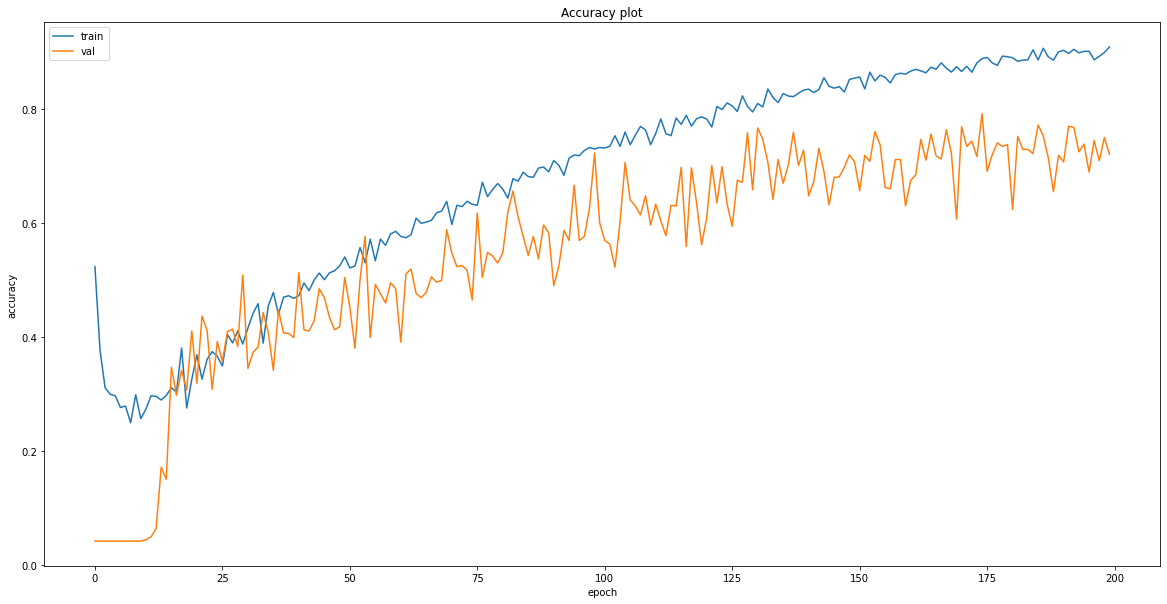

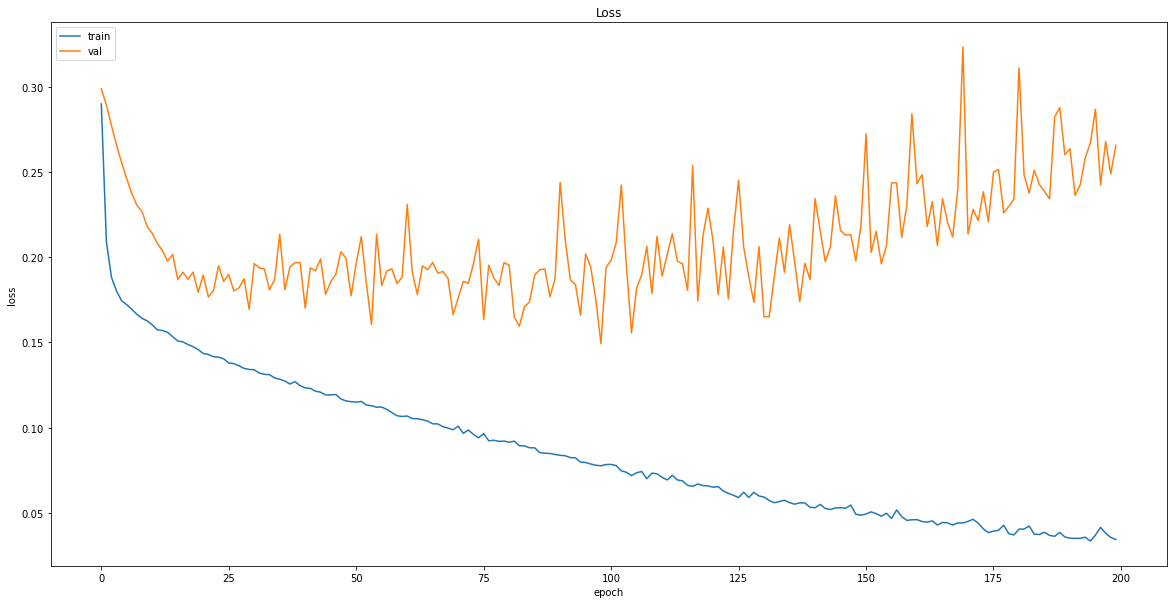

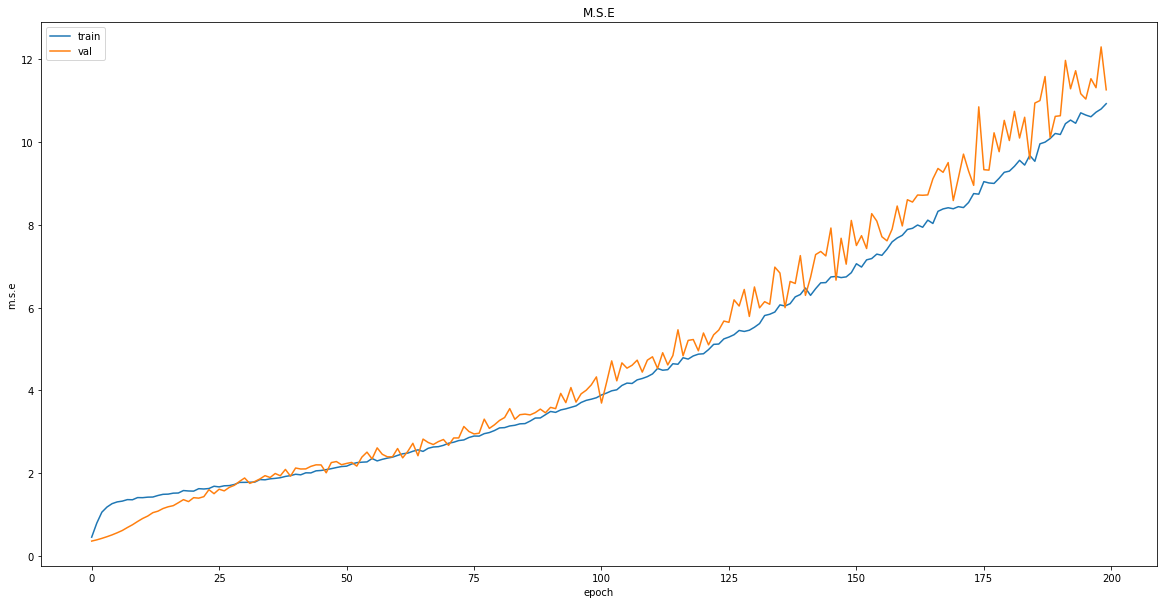

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [316]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [317]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-14,11.29,11.223146,-41.249981,448131022.0,2.0
2018-12-17,11.12,11.207277,-80.645176,443153122.0,0.0
2018-12-18,11.34,11.227696,-45.161256,448093822.0,2.0
2018-12-19,11.15,11.215743,-75.806509,440428782.0,2.0
2018-12-20,11.14,11.204090,-77.419295,435151482.0,2.0


In [318]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [319]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [320]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [321]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2858 - accuracy: 0.6743 - mean_squared_error: 14.0577 - weighted_accuracy: 0.6743 - weighted_mean_squared_error: 14.0577
Test loss: 0.2858324646949768
Test accuracy: 0.6743119359016418


In [322]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 158, 1: 35, 0: 25})

In [323]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [324]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-324-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-324-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-324-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,2,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


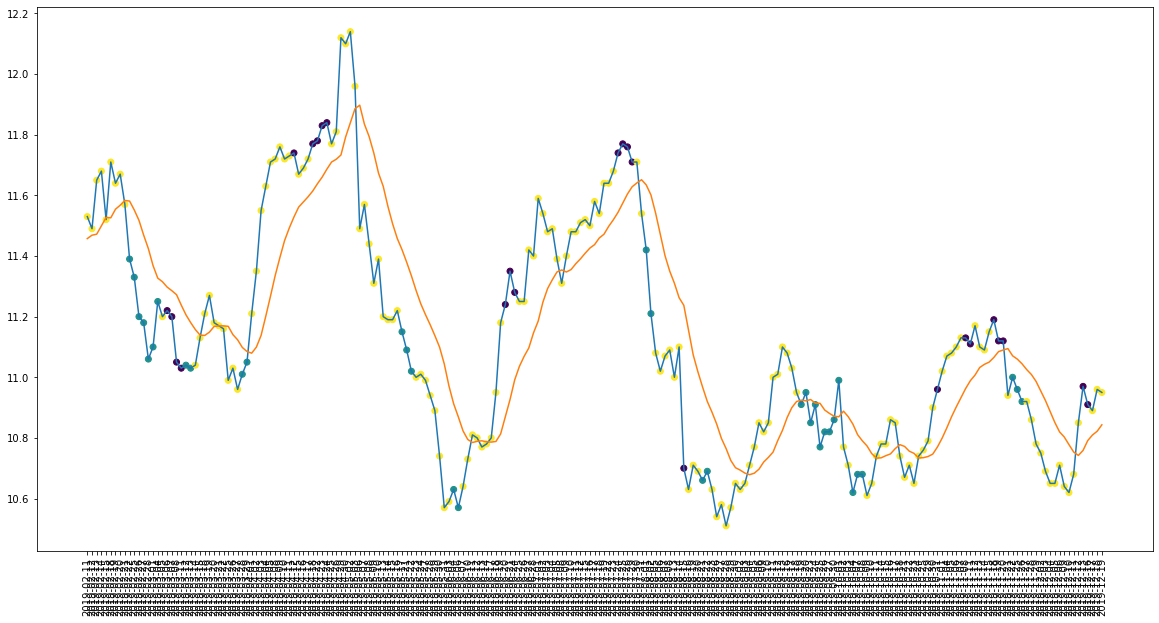

In [325]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

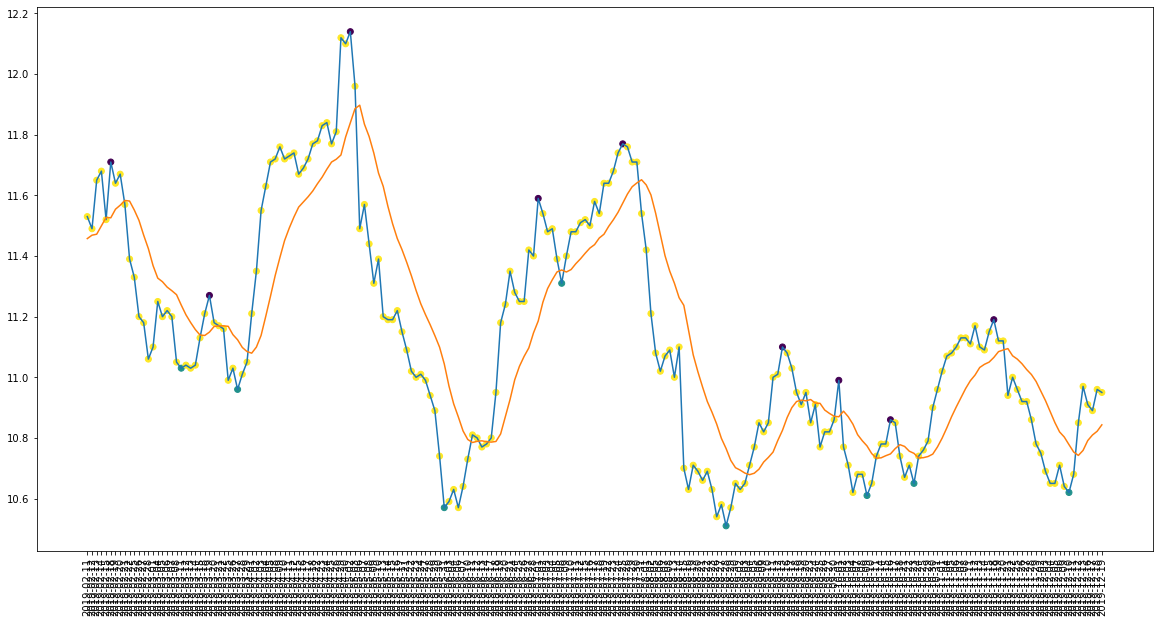

In [326]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [327]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 22
actual predicted holds: 145
Percentage buys correct: 0.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 72.13930348258707%
actual buys: 8
actual sells: 9
actual holds: 201


In [328]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 51.42857142857143%
Percentage sells correct: 76.0%
Percentage holds correct: 87.26114649681529%


In [329]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.390000343322756
Shares owned at the moment: 875
Cash capital at the moment: $6.3425112664681365


Stop Loss Activated!

Share price: $11.0600004196167
Shares owned at the moment: 0
Cash capital at the moment: $9657.229752421377


Share price: $11.0600004196167
Shares owned at the moment: 870
Cash capital at the moment: $8.56833635091607


Price increase from previously bought: 5.857168786761102%
Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10194.28018777132


Share price: $11.149999618530273
Shares owned at the moment: 911
Cash capital at the moment: $8.696998745916062


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9765.930405807969


Share price: $10.630000114440918
Shares owned at the moment: 916
Cash capital at the moment: $2.0733306918118615


Price increase from previously bought: 5.448489373977772%
Share price: $11.239999771118164
Shares owned at th

In [330]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


### recession

In [331]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-16,10.97,10.791319,-18.367351,53474942.0,2.0
2019-12-17,10.91,10.809578,-30.612316,49577542.0,2.0
2019-12-18,10.89,10.821951,-34.693842,45681342.0,2.0
2019-12-19,10.96,10.843189,-20.408211,50188142.0,2.0
2019-12-20,10.95,10.859621,-22.449071,47197442.0,2.0


In [332]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [333]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(215, 20, 4)

In [334]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [335]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3033 - accuracy: 0.7395 - mean_squared_error: 10.8660 - weighted_accuracy: 0.7395 - weighted_mean_squared_error: 10.8660
Test loss: 0.30326393246650696
Test accuracy: 0.739534854888916


In [336]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 176, 1: 28, 0: 11})

In [337]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [338]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-338-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-338-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-338-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


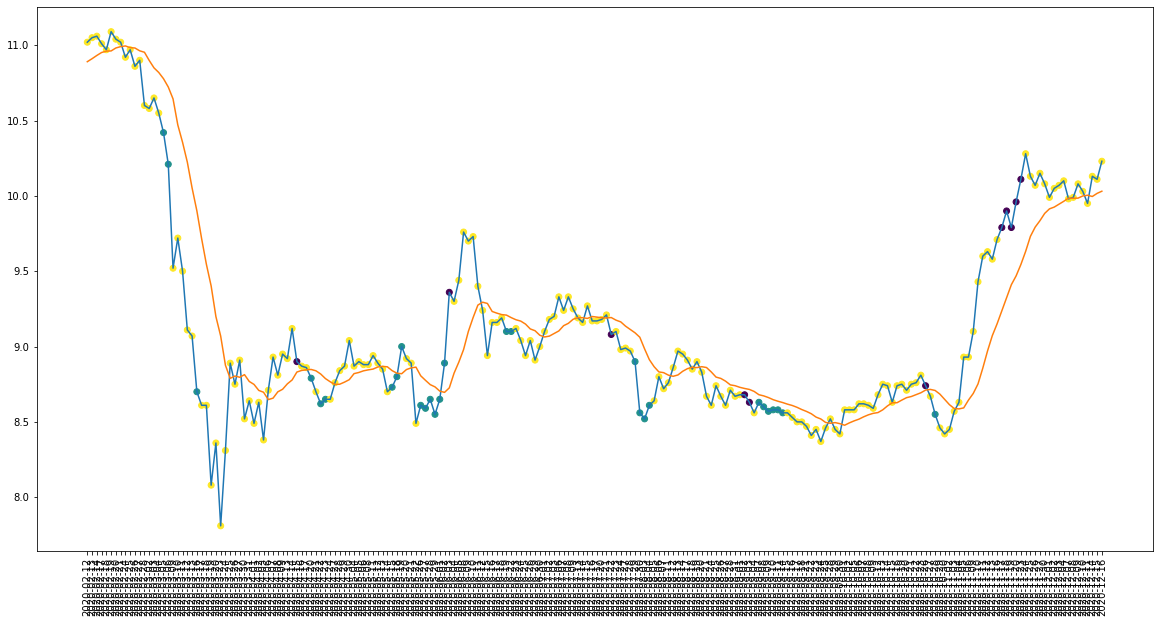

In [339]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

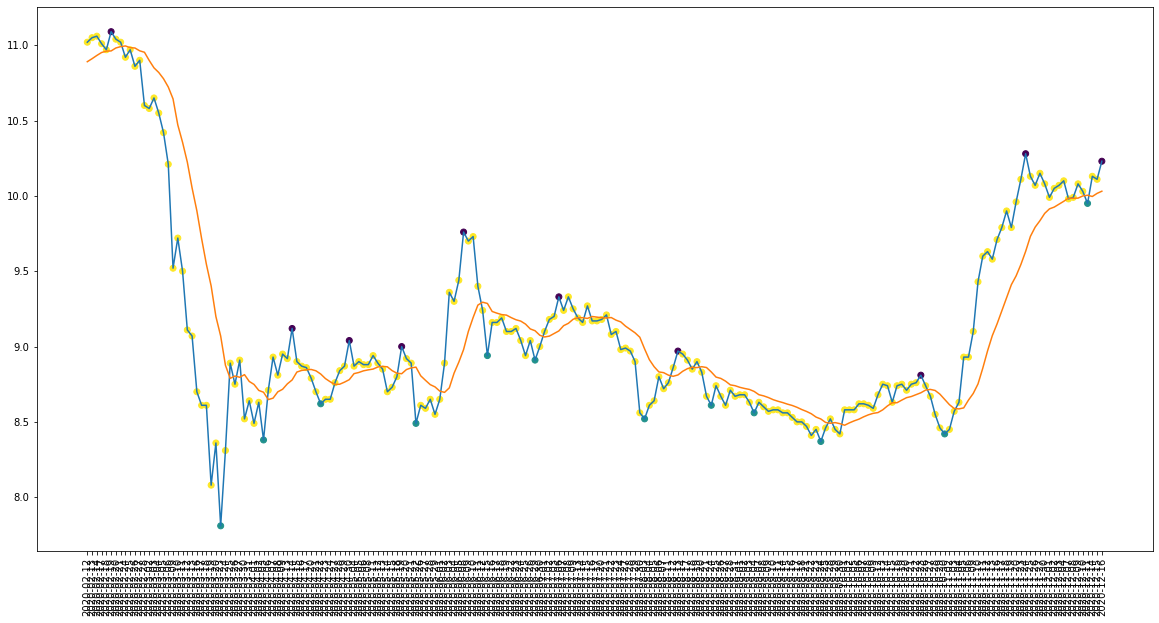

In [340]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [341]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 11
actual predicted holds: 157
Percentage buys correct: 16.666666666666668%
Percentage sells correct: 0.0%
Percentage holds correct: 81.34715025906736%
actual buys: 12
actual sells: 10
actual holds: 193


In [342]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 84.57142857142857%


In [343]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.420000076293944
Shares owned at the moment: 957
Cash capital at the moment: $0.6370917859094334


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9086.223268661024


Share price: $8.699999809265138
Shares owned at the moment: 1041
Cash capital at the moment: $4.617542762040102


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8392.766443558454


Share price: $8.789999961853027
Shares owned at the moment: 952
Cash capital at the moment: $1.6742599742410675


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8061.927222677946


Share price: $8.609999656677246
Shares owned at the moment: 933
Cash capital at the moment: $6.706436378955004


Price increase from previously bought: 8.412666907075984%
Share price: $9.359999656677246
Shares owned at the moment: 0
Cash capital at the momen

In [344]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [95]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


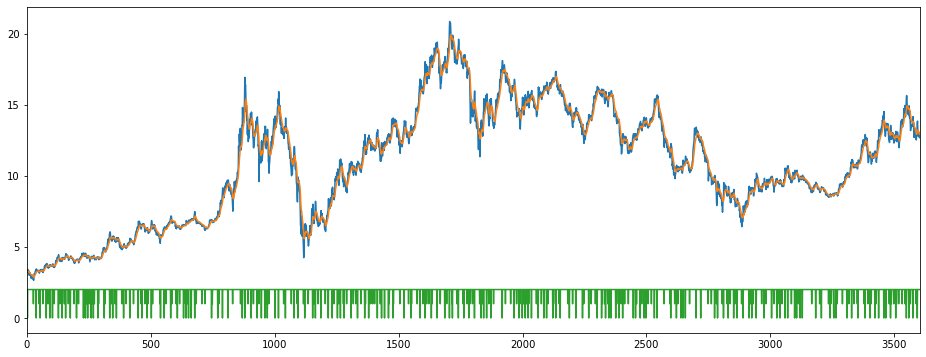

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [97]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-04-07,3.250,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.200,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.250,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.375,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.275,3.272993,-52.083331,47190715.0,2.0


In [98]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

In [99]:
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
X.shape

(3585, 20, 4)

In [100]:
y = labels
y = np.array(y)

In [101]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [102]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [103]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [105]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 37ms/step - loss: 0.3015 - accuracy: 0.5558 - mse: 0.4134 - weighted_accuracy: 0.3277 - weighted_mse: 0.5031 - val_loss: 0.3009 - val_accuracy: 0.0474 - val_mse: 0.3508 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.3508
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2206 - accuracy: 0.4236 - mse: 0.6748 - weighted_accuracy: 0.4096 - weighted_mse: 0.6812 - val_loss: 0.2942 - val_accuracy: 0.0446 - val_mse: 0.3705 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3705
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1946 - accuracy: 0.3734 - mse: 0.8855 - weighted_accuracy: 0.4585 - weighted_mse: 0.8751 - val_loss: 0.2866 - val_accuracy: 0.0446 - val_mse: 0.3972 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3972
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1841 - accuracy: 0.3156 - mse: 1.0483 - weighted_accuracy: 0.4904 - weighte

Epoch 30/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1364 - accuracy: 0.3937 - mse: 1.6081 - weighted_accuracy: 0.7317 - weighted_mse: 1.5373 - val_loss: 0.1726 - val_accuracy: 0.4589 - val_mse: 1.3768 - val_weighted_accuracy: 0.4589 - val_weighted_mse: 1.3768
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.3884 - mse: 1.6246 - weighted_accuracy: 0.7248 - weighted_mse: 1.5441 - val_loss: 0.1752 - val_accuracy: 0.4491 - val_mse: 1.4801 - val_weighted_accuracy: 0.4491 - val_weighted_mse: 1.4801
Epoch 32/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.4435 - mse: 1.6204 - weighted_accuracy: 0.7355 - weighted_mse: 1.5652 - val_loss: 0.1751 - val_accuracy: 0.4449 - val_mse: 1.4672 - val_weighted_accuracy: 0.4449 - val_weighted_mse: 1.4672
Epoch 33/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1335 - accuracy: 0.4261 - mse: 1.6789 - weighted_accuracy: 0.7267 - weig

Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.5837 - mse: 2.0862 - weighted_accuracy: 0.8088 - weighted_mse: 2.0971 - val_loss: 0.1720 - val_accuracy: 0.5035 - val_mse: 2.0903 - val_weighted_accuracy: 0.5035 - val_weighted_mse: 2.0903
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.6011 - mse: 2.1283 - weighted_accuracy: 0.8079 - weighted_mse: 2.1503 - val_loss: 0.1751 - val_accuracy: 0.4909 - val_mse: 2.2374 - val_weighted_accuracy: 0.4909 - val_weighted_mse: 2.2374
Epoch 61/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1090 - accuracy: 0.5819 - mse: 2.1425 - weighted_accuracy: 0.8176 - weighted_mse: 2.1377 - val_loss: 0.1850 - val_accuracy: 0.4658 - val_mse: 2.1603 - val_weighted_accuracy: 0.4658 - val_weighted_mse: 2.1603
Epoch 62/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1074 - accuracy: 0.5990 - mse: 2.1657 - weighted_accuracy: 0.8215 - weig

Epoch 88/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.7089 - mse: 2.7049 - weighted_accuracy: 0.8787 - weighted_mse: 2.7557 - val_loss: 0.1773 - val_accuracy: 0.5537 - val_mse: 2.8030 - val_weighted_accuracy: 0.5537 - val_weighted_mse: 2.8030
Epoch 89/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0857 - accuracy: 0.6998 - mse: 2.7292 - weighted_accuracy: 0.8778 - weighted_mse: 2.8081 - val_loss: 0.1615 - val_accuracy: 0.6304 - val_mse: 2.7936 - val_weighted_accuracy: 0.6304 - val_weighted_mse: 2.7936
Epoch 90/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0869 - accuracy: 0.7340 - mse: 2.7868 - weighted_accuracy: 0.8807 - weighted_mse: 2.8555 - val_loss: 0.1655 - val_accuracy: 0.6053 - val_mse: 3.0350 - val_weighted_accuracy: 0.6053 - val_weighted_mse: 3.0350
Epoch 91/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0853 - accuracy: 0.6785 - mse: 2.8463 - weighted_accuracy: 0.8724 - weig

Epoch 117/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0700 - accuracy: 0.7918 - mse: 3.6320 - weighted_accuracy: 0.9140 - weighted_mse: 3.6892 - val_loss: 0.1670 - val_accuracy: 0.6764 - val_mse: 3.6796 - val_weighted_accuracy: 0.6764 - val_weighted_mse: 3.6796
Epoch 118/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0671 - accuracy: 0.7720 - mse: 3.6794 - weighted_accuracy: 0.9044 - weighted_mse: 3.7700 - val_loss: 0.1789 - val_accuracy: 0.6388 - val_mse: 3.9025 - val_weighted_accuracy: 0.6388 - val_weighted_mse: 3.9025
Epoch 119/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.7911 - mse: 3.7201 - weighted_accuracy: 0.9113 - weighted_mse: 3.7718 - val_loss: 0.1590 - val_accuracy: 0.7294 - val_mse: 3.9308 - val_weighted_accuracy: 0.7294 - val_weighted_mse: 3.9308
Epoch 120/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.7671 - mse: 3.7678 - weighted_accuracy: 0.9001 - 

23/23 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.8246 - mse: 4.8755 - weighted_accuracy: 0.9237 - weighted_mse: 4.8095 - val_loss: 0.1987 - val_accuracy: 0.6681 - val_mse: 5.0341 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 5.0341
Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8295 - mse: 4.9198 - weighted_accuracy: 0.9326 - weighted_mse: 4.8262 - val_loss: 0.1738 - val_accuracy: 0.7225 - val_mse: 5.2990 - val_weighted_accuracy: 0.7225 - val_weighted_mse: 5.2990
Epoch 147/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.8354 - mse: 4.9182 - weighted_accuracy: 0.9348 - weighted_mse: 4.8484 - val_loss: 0.1832 - val_accuracy: 0.7225 - val_mse: 5.4656 - val_weighted_accuracy: 0.7225 - val_weighted_mse: 5.4656
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0535 - accuracy: 0.8400 - mse: 5.0804 - weighted_accuracy: 0.9365 - weighted_mse: 

Epoch 174/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.8752 - mse: 6.4302 - weighted_accuracy: 0.9493 - weighted_mse: 6.0456 - val_loss: 0.1949 - val_accuracy: 0.7559 - val_mse: 6.8342 - val_weighted_accuracy: 0.7559 - val_weighted_mse: 6.8342
Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.8874 - mse: 6.5780 - weighted_accuracy: 0.9563 - weighted_mse: 6.1461 - val_loss: 0.2136 - val_accuracy: 0.6987 - val_mse: 6.6307 - val_weighted_accuracy: 0.6987 - val_weighted_mse: 6.6307
Epoch 176/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.8856 - mse: 6.6089 - weighted_accuracy: 0.9580 - weighted_mse: 6.2056 - val_loss: 0.2157 - val_accuracy: 0.7183 - val_mse: 6.8461 - val_weighted_accuracy: 0.7183 - val_weighted_mse: 6.8461
Epoch 177/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.8930 - mse: 6.8180 - weighted_accuracy: 0.9583 - 

In [106]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21677124500274658
Test accuracy: 0.767085075378418


In [107]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6214164  -1.7003751   0.26049381]
 [-4.2528296   0.23787308 -1.0679361 ]
 [-4.961456   -6.060859    4.6818075 ]
 ...
 [-3.2605417  -5.7348857   2.8095584 ]
 [-2.835429   -0.74363965  0.55666035]
 [-4.66898    -3.8470132   3.9881415 ]]


Counter({2: 603, 1: 64, 0: 50})

In [108]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 652, 0: 33, 1: 32})

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 717
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 28
actual sells but predicted buy: 2
actual predicted sells: 1
actual sells but predicted hold: 30
actual holds but predicted buy: 58
actual holds but predicted sell: 49
actual predicted holds: 545
Percentage buys correct: 12.5%
Percentage sells correct: 3.0303030303030303%
Percentage holds correct: 83.58895705521472%
actual buys: 32
actual sells: 33
actual holds: 652


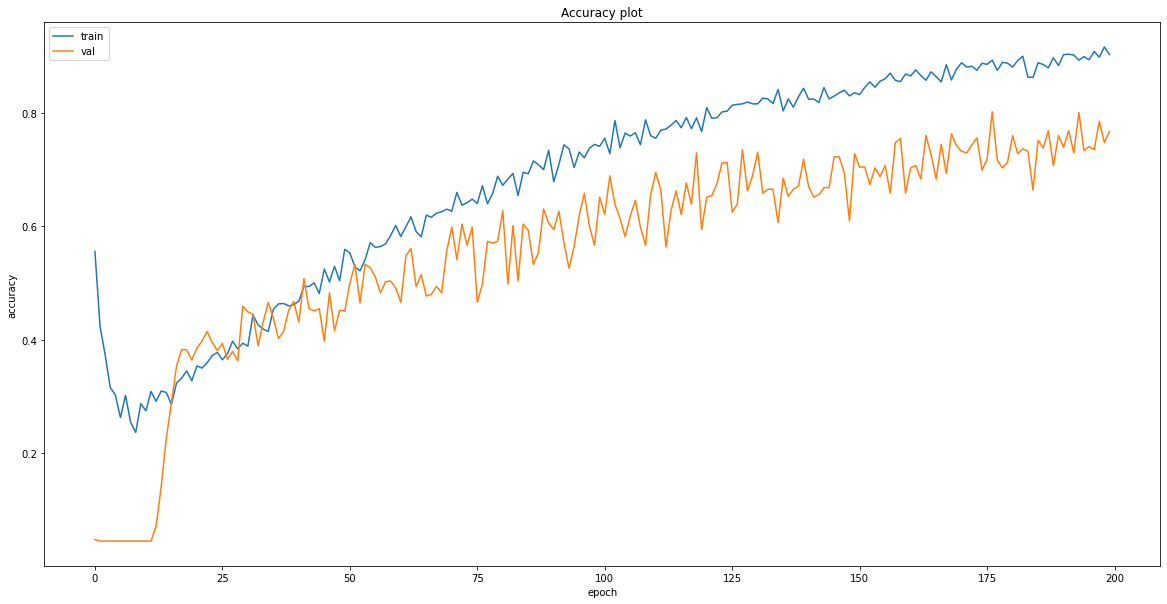

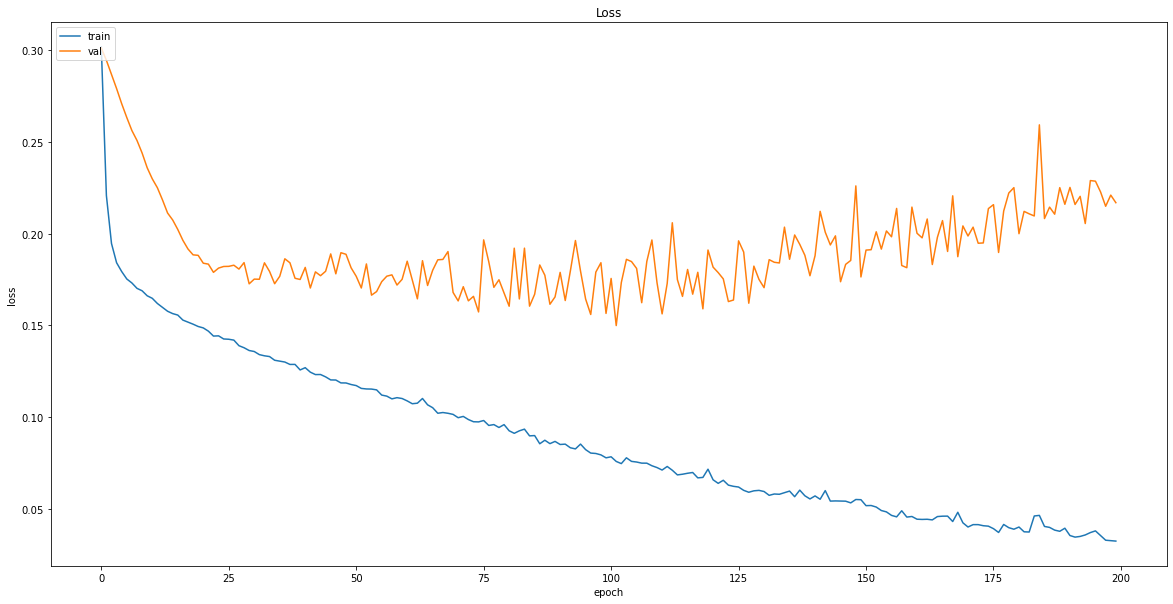

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [112]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-12,12.74,13.032944,-77.906974,9.460210e+09,2.0
2018-12-13,12.74,12.987876,-77.906974,9.460210e+09,2.0
2018-12-14,13.06,12.998972,-59.302288,9.506982e+09,2.0
2018-12-17,12.80,12.968361,-78.048748,9.447852e+09,2.0
2018-12-18,12.68,12.923998,-95.890382,9.410332e+09,2.0


In [113]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(211, 20, 4)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1891 - accuracy: 0.7725 - mean_squared_error: 7.4981 - weighted_accuracy: 0.7725 - weighted_mean_squared_error: 7.4981
Test loss: 0.18909341096878052
Test accuracy: 0.7725118398666382


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 0: 11, 1: 22})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [118]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-118-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-118-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-118-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,2,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,2,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


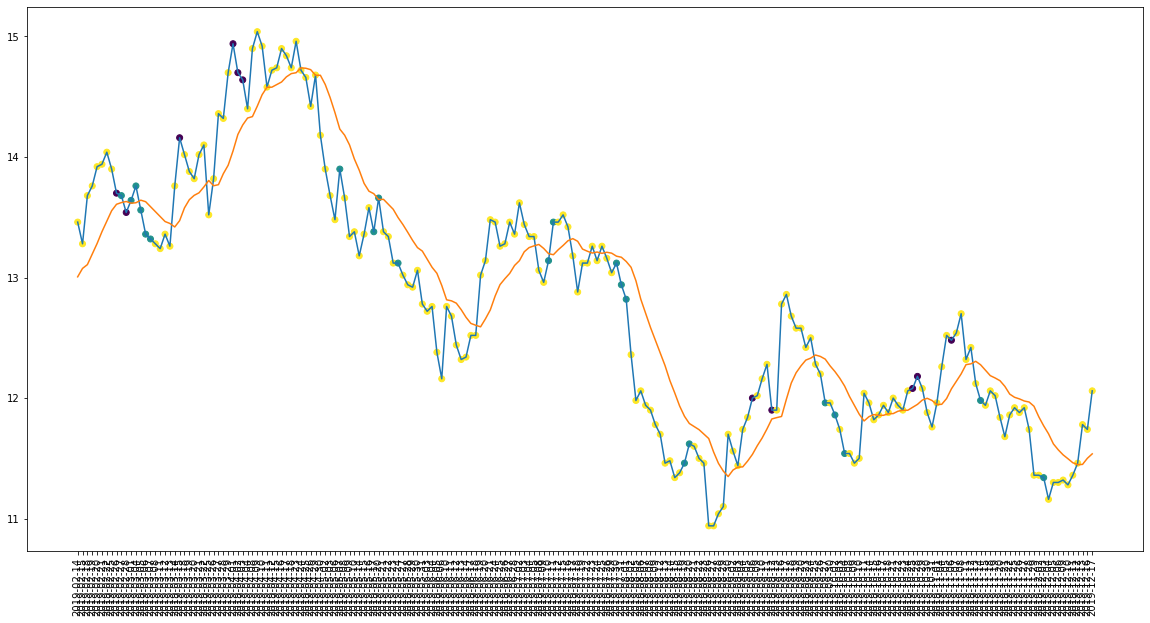

In [119]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

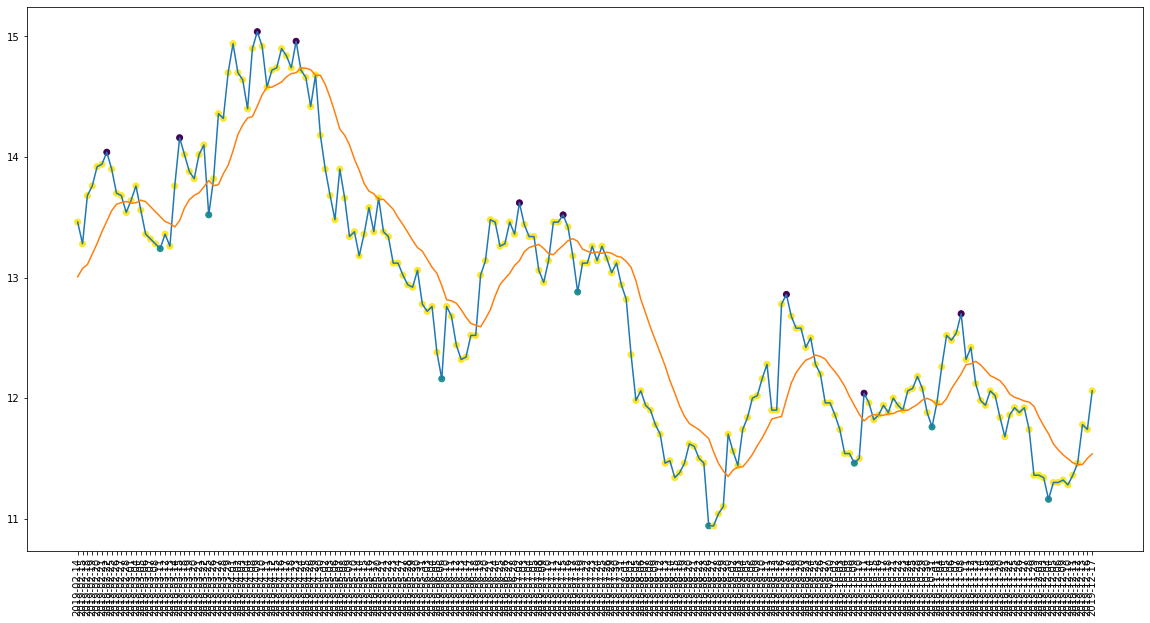

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 22
actual holds but predicted sell: 10
actual predicted holds: 162
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 83.50515463917526%
actual buys: 8
actual sells: 9
actual holds: 194


In [122]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 83.05084745762711%


In [123]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.899999618530273
Shares owned at the moment: 692
Cash capital at the moment: $9.574228061679605


Stop Loss Activated!

Share price: $13.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9215.468313362126


Share price: $13.380000114440918
Shares owned at the moment: 686
Cash capital at the moment: $11.546864639762134


Stop Loss Activated!

Share price: $12.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $8863.975267574313


Share price: $13.140000343322756
Shares owned at the moment: 672
Cash capital at the moment: $9.612316226959592


Stop Loss Activated!

Share price: $12.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $8292.690806148526


Share pric

In [124]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [125]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-12,11.36,11.447620,-75.000025,-214227973.0,2.0
2019-12-13,11.46,11.449525,-64.583319,-167306085.0,2.0
2019-12-16,11.78,11.500367,-31.250019,-82839244.0,2.0
2019-12-17,11.74,11.537234,-31.111168,-127828316.0,2.0
2019-12-18,12.06,11.617659,-5.999947,-67007162.0,2.0


In [126]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(213, 20, 4)

In [127]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [128]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1731 - accuracy: 0.8545 - mean_squared_error: 8.2888 - weighted_accuracy: 0.8545 - weighted_mean_squared_error: 8.2888
Test loss: 0.17313252389431
Test accuracy: 0.8544601202011108


In [129]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 1: 12, 0: 5})

In [130]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [131]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-131-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-131-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-131-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


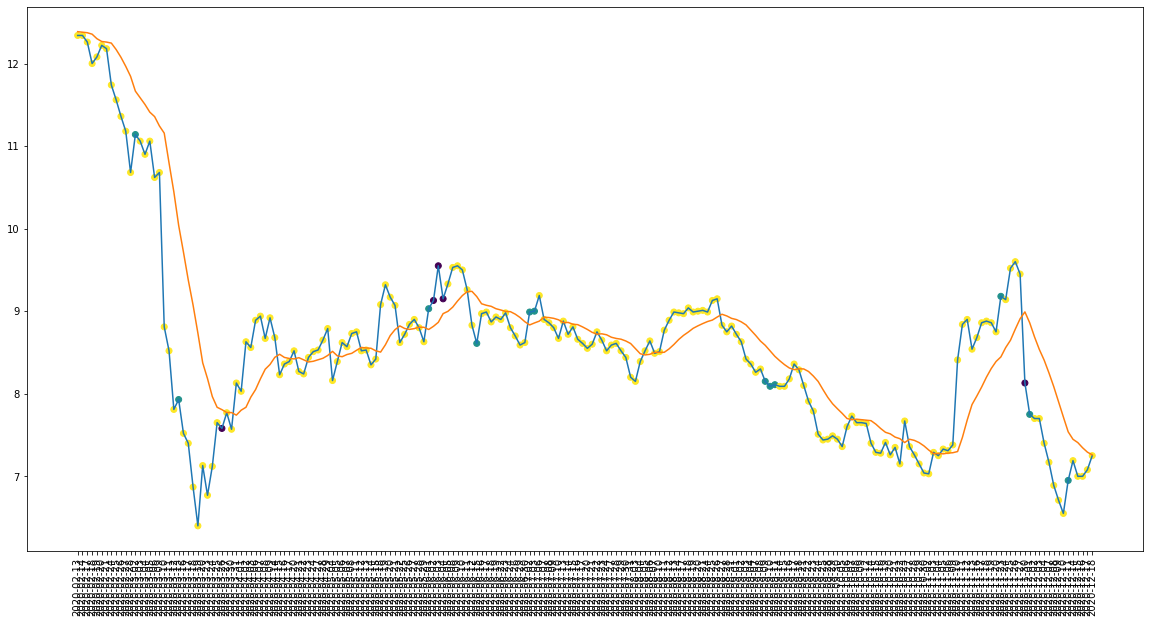

In [132]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

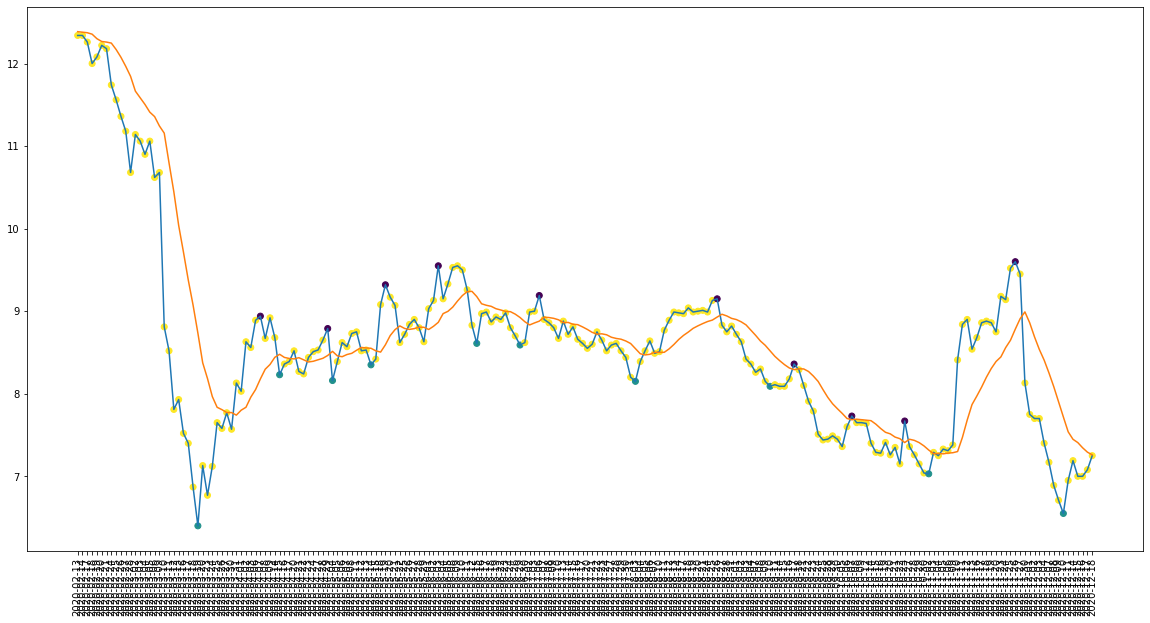

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [134]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 4
actual predicted holds: 179
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 92.74611398963731%
actual buys: 10
actual sells: 10
actual holds: 193


In [135]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 20.0%
Percentage holds correct: 82.56410256410257%


In [136]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.140000343322754
Shares owned at the moment: 895
Cash capital at the moment: $2.2813668811322714


Stop Loss Activated!

Share price: $10.619999885559082
Shares owned at the moment: 0
Cash capital at the moment: $9481.042789738178


Share price: $7.929999828338622
Shares owned at the moment: 1192
Cash capital at the moment: $2.4884549212474667


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8941.677872248174


Share price: $9.029999732971193
Shares owned at the moment: 987
Cash capital at the moment: $4.558459030389713


Price increase from previously bought: 5.468549232034481%
Share price: $9.550000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9404.487559267998


Share price: $8.609999656677246
Shares owned at the moment: 1089
Cash capital at the moment: $2.4131366746423737


Stop Loss Activated!

Share price: $8.199999809265138
Shares owned at the moment: 0
Cash capital at the mo

In [137]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [138]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


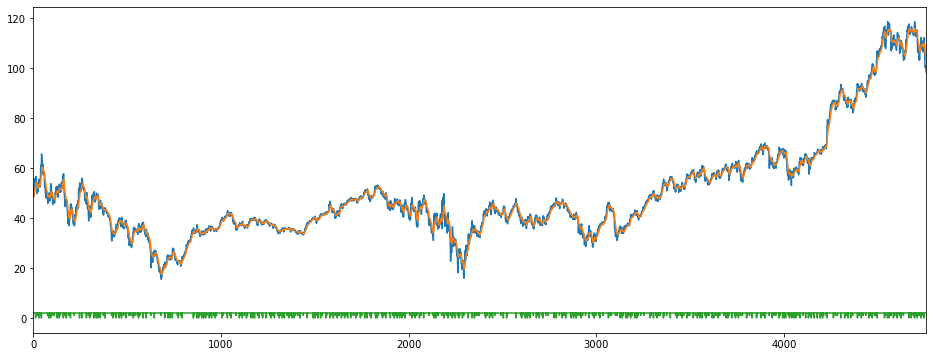

In [139]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [140]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [141]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(4740, 20, 4)

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[0 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2925 - accuracy: 0.5053 - mse: 0.4752 - weighted_accuracy: 0.3107 - weighted_mse: 0.5497 - val_loss: 0.2987 - val_accuracy: 0.0475 - val_mse: 0.3540 - val_weighted_accuracy: 0.0475 - val_weighted_mse: 0.3540
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.3747 - mse: 0.7722 - weighted_accuracy: 0.4209 - weighted_mse: 0.7731 - val_loss: 0.2900 - val_accuracy: 0.0454 - val_mse: 0.3857 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3857
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1921 - accuracy: 0.2869 - mse: 1.0202 - weighted_accuracy: 0.4739 - weighted_mse: 0.9886 - val_loss: 0.2806 - val_accuracy: 0.0454 - val_mse: 0.4275 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4275
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1837 - accuracy: 0.2624 - mse: 1.1599 - weighted_accuracy: 0.4894 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.3874 - mse: 1.7058 - weighted_accuracy: 0.7039 - weighted_mse: 1.6036 - val_loss: 0.1859 - val_accuracy: 0.3819 - val_mse: 1.6424 - val_weighted_accuracy: 0.3819 - val_weighted_mse: 1.6424
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1375 - accuracy: 0.3966 - mse: 1.7230 - weighted_accuracy: 0.7147 - weighted_mse: 1.6207 - val_loss: 0.2035 - val_accuracy: 0.3017 - val_mse: 1.7257 - val_weighted_accuracy: 0.3017 - val_weighted_mse: 1.7257
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.3972 - mse: 1.7550 - weighted_accuracy: 0.7185 - weighted_mse: 1.6486 - val_loss: 0.1933 - val_accuracy: 0.3207 - val_mse: 1.7943 - val_weighted_accuracy: 0.3207 - val_weighted_mse: 1.7943
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.3916 - mse: 1.7833 - weighted_accuracy: 0.7222 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.5641 - mse: 2.2664 - weighted_accuracy: 0.8043 - weighted_mse: 2.1965 - val_loss: 0.1640 - val_accuracy: 0.5359 - val_mse: 2.2676 - val_weighted_accuracy: 0.5359 - val_weighted_mse: 2.2676
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.5509 - mse: 2.3237 - weighted_accuracy: 0.7979 - weighted_mse: 2.2474 - val_loss: 0.1823 - val_accuracy: 0.4715 - val_mse: 2.3605 - val_weighted_accuracy: 0.4715 - val_weighted_mse: 2.3605
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1099 - accuracy: 0.5786 - mse: 2.3189 - weighted_accuracy: 0.8058 - weighted_mse: 2.2650 - val_loss: 0.1960 - val_accuracy: 0.4103 - val_mse: 2.3171 - val_weighted_accuracy: 0.4103 - val_weighted_mse: 2.3171
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1108 - accuracy: 0.5588 - mse: 2.3568 - weighted_accuracy: 0.7986 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0891 - accuracy: 0.6867 - mse: 3.1371 - weighted_accuracy: 0.8570 - weighted_mse: 3.0886 - val_loss: 0.1893 - val_accuracy: 0.5179 - val_mse: 3.0523 - val_weighted_accuracy: 0.5179 - val_weighted_mse: 3.0523
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0856 - accuracy: 0.7044 - mse: 3.1551 - weighted_accuracy: 0.8768 - weighted_mse: 3.0858 - val_loss: 0.1964 - val_accuracy: 0.5095 - val_mse: 3.2607 - val_weighted_accuracy: 0.5095 - val_weighted_mse: 3.2607
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0861 - accuracy: 0.6938 - mse: 3.2386 - weighted_accuracy: 0.8727 - weighted_mse: 3.1802 - val_loss: 0.1530 - val_accuracy: 0.6445 - val_mse: 3.3053 - val_weighted_accuracy: 0.6445 - val_weighted_mse: 3.3053
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0843 - accuracy: 0.7057 - mse: 3.2905 - weighted_accuracy: 0.8810 - weig

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0654 - accuracy: 0.7898 - mse: 4.4188 - weighted_accuracy: 0.9136 - weighted_mse: 4.2694 - val_loss: 0.2114 - val_accuracy: 0.5717 - val_mse: 4.6080 - val_weighted_accuracy: 0.5717 - val_weighted_mse: 4.6080
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0633 - accuracy: 0.7938 - mse: 4.4453 - weighted_accuracy: 0.9227 - weighted_mse: 4.2730 - val_loss: 0.1547 - val_accuracy: 0.7331 - val_mse: 4.7377 - val_weighted_accuracy: 0.7331 - val_weighted_mse: 4.7377
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.8093 - mse: 4.5936 - weighted_accuracy: 0.9208 - weighted_mse: 4.4392 - val_loss: 0.1991 - val_accuracy: 0.6013 - val_mse: 4.7076 - val_weighted_accuracy: 0.6013 - val_weighted_mse: 4.7076
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.7882 - mse: 4.6049 - weighted_accuracy: 0.9131 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0528 - accuracy: 0.8447 - mse: 6.1546 - weighted_accuracy: 0.9337 - weighted_mse: 5.7353 - val_loss: 0.1842 - val_accuracy: 0.7563 - val_mse: 6.6431 - val_weighted_accuracy: 0.7563 - val_weighted_mse: 6.6431
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.8539 - mse: 6.1248 - weighted_accuracy: 0.9390 - weighted_mse: 5.7252 - val_loss: 0.2546 - val_accuracy: 0.5823 - val_mse: 5.7426 - val_weighted_accuracy: 0.5823 - val_weighted_mse: 5.7426
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0474 - accuracy: 0.8531 - mse: 6.2593 - weighted_accuracy: 0.9406 - weighted_mse: 5.8413 - val_loss: 0.1986 - val_accuracy: 0.7110 - val_mse: 6.4560 - val_weighted_accuracy: 0.7110 - val_weighted_mse: 6.4560
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0507 - accuracy: 0.8494 - mse: 6.3448 - weighted_accuracy: 0.9316 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.8895 - mse: 8.1982 - weighted_accuracy: 0.9540 - weighted_mse: 7.3981 - val_loss: 0.2142 - val_accuracy: 0.7542 - val_mse: 8.3963 - val_weighted_accuracy: 0.7542 - val_weighted_mse: 8.3963
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 0.9008 - mse: 8.3520 - weighted_accuracy: 0.9637 - weighted_mse: 7.4733 - val_loss: 0.2062 - val_accuracy: 0.7627 - val_mse: 8.4589 - val_weighted_accuracy: 0.7627 - val_weighted_mse: 8.4589
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9024 - mse: 8.4204 - weighted_accuracy: 0.9625 - weighted_mse: 7.5132 - val_loss: 0.2165 - val_accuracy: 0.7511 - val_mse: 8.4977 - val_weighted_accuracy: 0.7511 - val_weighted_mse: 8.4977
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0363 - accuracy: 0.8979 - mse: 8.5621 - weighted_accuracy: 0.9608 - 

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.24003227055072784
Test accuracy: 0.7721518874168396


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.4372718  -0.7935431   0.17189083]
 [-4.318598   -6.75423     4.1189194 ]
 [ 0.68306303 -3.4141626  -1.3193271 ]
 ...
 [-3.7434614  -3.4438326   2.528032  ]
 [-0.8025965  -1.7950965  -0.7810828 ]
 [-3.3740203  -1.4319365   0.50677156]]


Counter({2: 804, 0: 84, 1: 60})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 41, 1: 43})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 40
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 37
actual holds but predicted buy: 57
actual holds but predicted sell: 80
actual predicted holds: 727
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 84.14351851851852%
actual buys: 43
actual sells: 41
actual holds: 864


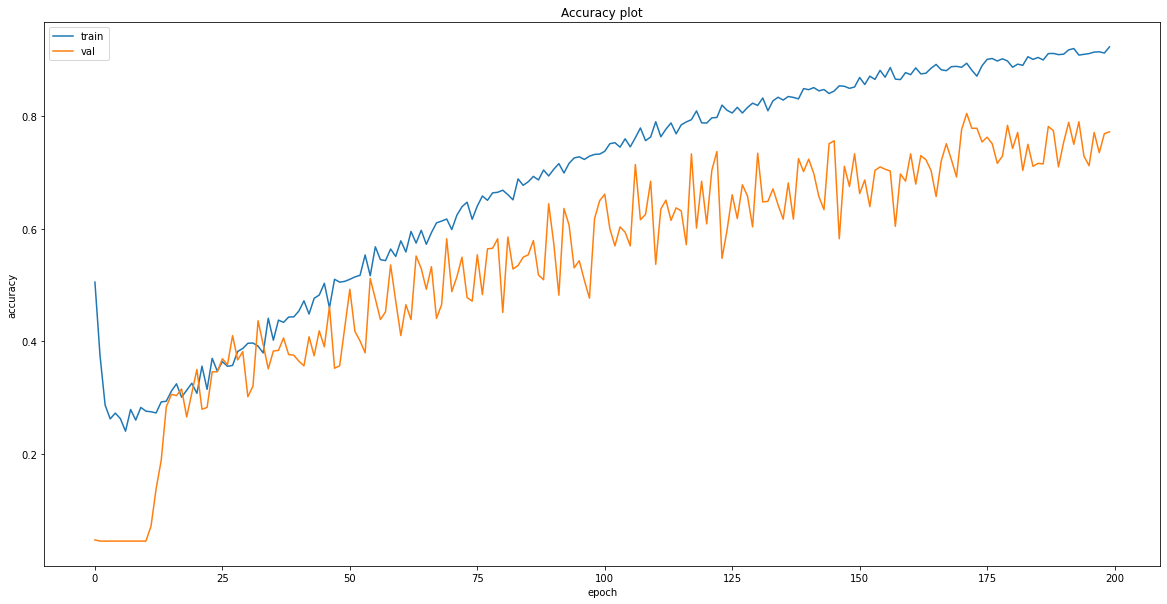

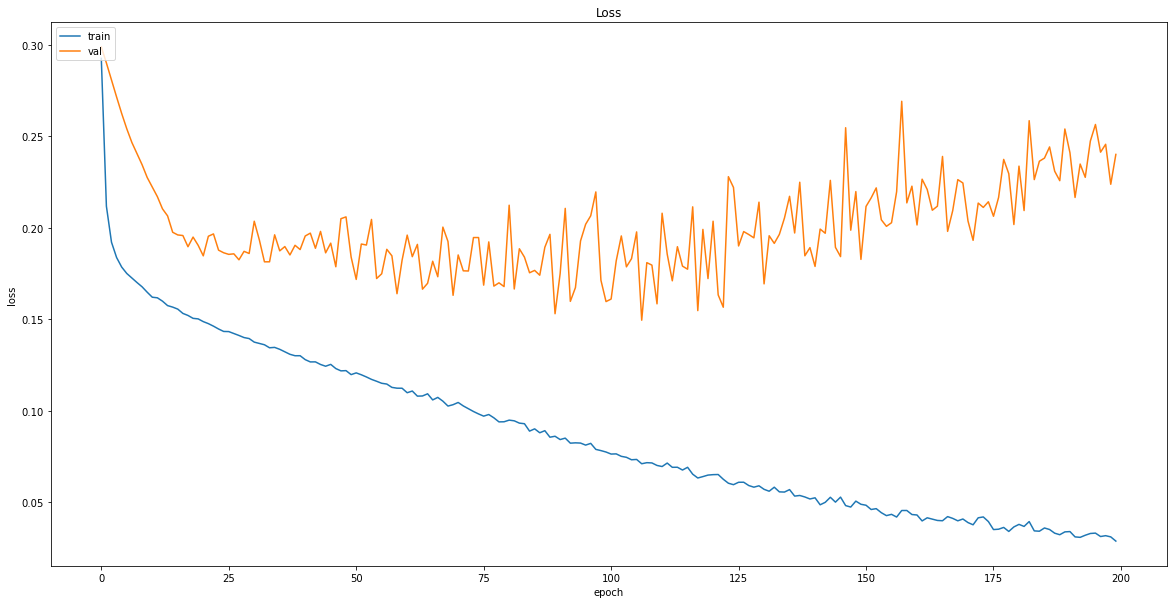

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [153]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,101.019997,105.247250,-87.215299,-1.989079e+09,2.0
2018-12-14,101.120003,104.612289,-86.480500,-1.971828e+09,2.0
2018-12-17,100.290001,103.947322,-92.578971,-1.991708e+09,2.0
2018-12-18,99.010002,103.187734,-96.055365,-2.016821e+09,2.0
2018-12-19,98.540001,102.472698,-97.156410,-2.037658e+09,2.0


In [154]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [155]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [156]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.8257 - mean_squared_error: 11.0753 - weighted_accuracy: 0.8257 - weighted_mean_squared_error: 11.0753
Test loss: 0.15782207250595093
Test accuracy: 0.8256880640983582


In [157]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 188, 1: 17, 0: 13})

In [158]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [159]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-159-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-159-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-159-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


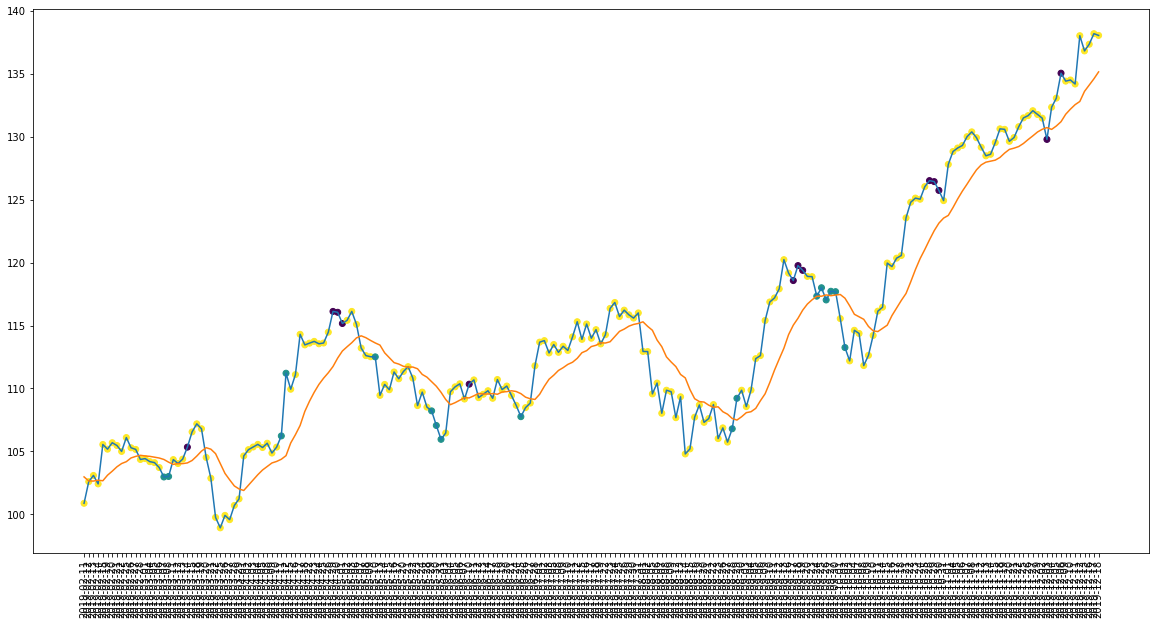

In [160]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

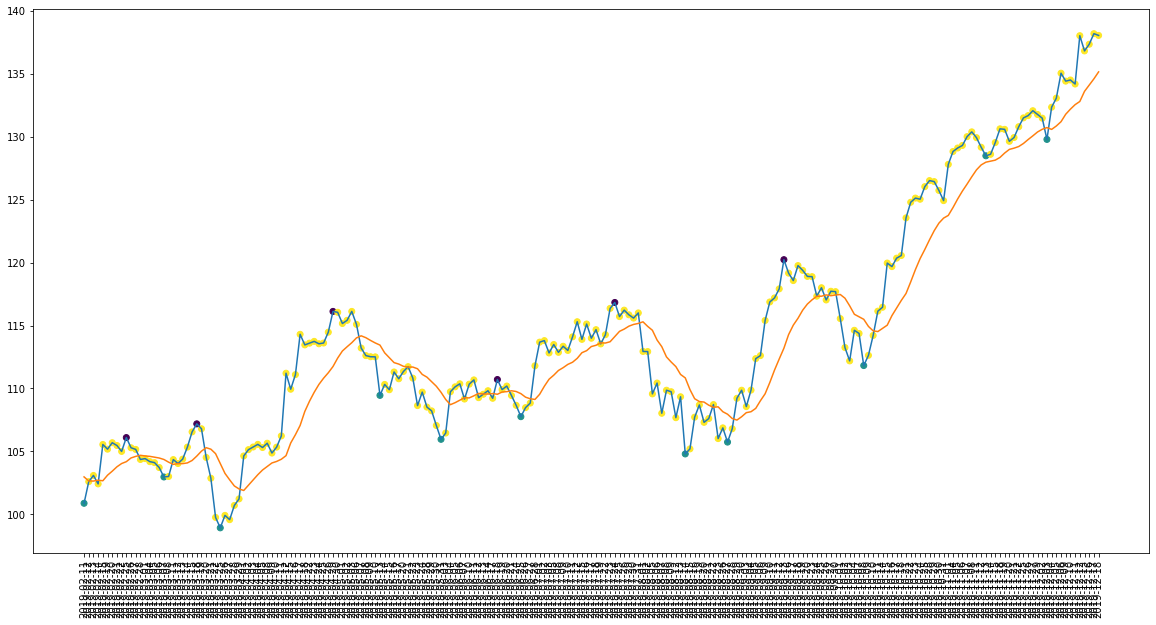

In [161]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [162]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 14
actual holds but predicted sell: 11
actual predicted holds: 176
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 87.56218905472637%
actual buys: 11
actual sells: 6
actual holds: 201


In [163]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 69.23076923076923%
Percentage holds correct: 86.09625668449198%


In [164]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $102.97000122070312
Shares owned at the moment: 96
Cash capital at the moment: $87.6958024902342


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9638.319367004397


Share price: $106.2300033569336
Shares owned at the moment: 90
Cash capital at the moment: $51.32713904953198


Price increase from previously bought: 9.010208819391007%
Share price: $116.12000274658205
Shares owned at the moment: 0
Cash capital at the moment: $10473.387685562137


Share price: $112.51000213623048
Shares owned at the moment: 92
Cash capital at the moment: $94.00245848846498


Stop Loss Activated!

Share price: $108.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10061.39648249054


Share price: $108.22000122070312
Shares owned at the moment: 92
Cash capital at the moment: $77.77670987701458


Stop Loss Activated!

Share price: $104.8000030517578
Shares owned at the moment: 0
Cash capital at the moment: 

In [165]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [166]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,138.020004,133.597310,-4.554623,284280700.0,2.0
2019-12-16,136.809998,134.091570,-19.726594,273688600.0,2.0
2019-12-17,137.339996,134.591328,-14.634146,285060600.0,2.0
2019-12-18,138.179993,135.143430,-6.439060,296607400.0,2.0
2019-12-19,138.039993,135.589055,-9.396071,286225900.0,2.0


In [167]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(219, 20, 4)

In [168]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [169]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.8311 - mean_squared_error: 12.8568 - weighted_accuracy: 0.8311 - weighted_mean_squared_error: 12.8568
Test loss: 0.18085625767707825
Test accuracy: 0.8310502171516418


In [170]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 195, 1: 16, 0: 8})

In [171]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [172]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-172-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-172-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-172-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,2,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


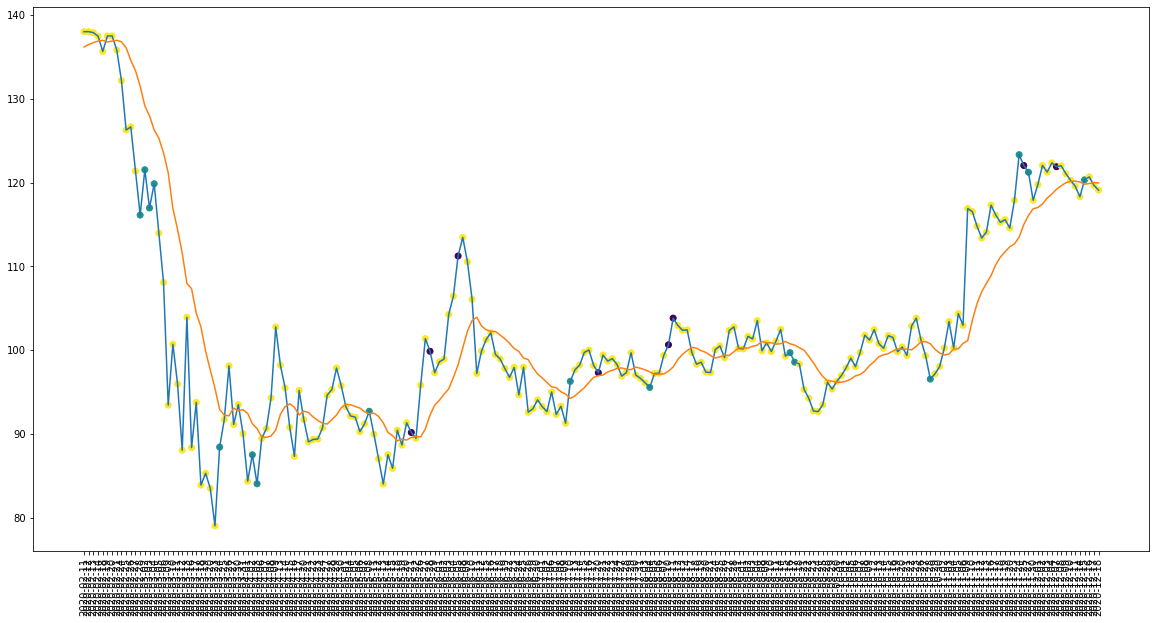

In [173]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

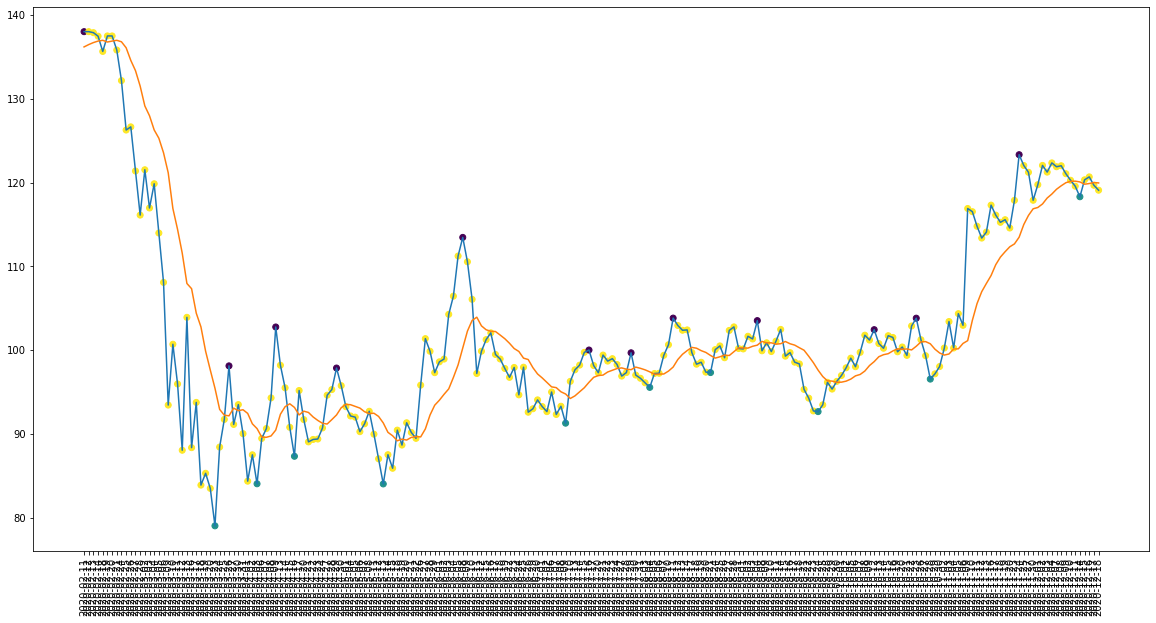

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 12
actual holds but predicted sell: 7
actual predicted holds: 178
Percentage buys correct: 30.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 90.35532994923858%
actual buys: 10
actual sells: 12
actual holds: 197


In [176]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 31.25%
Percentage sells correct: 62.5%
Percentage holds correct: 84.02061855670104%


In [177]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $116.11000061035156
Shares owned at the moment: 85
Cash capital at the moment: $103.50923547744787


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $9265.045690689087


Share price: $88.43000030517578
Shares owned at the moment: 104
Cash capital at the moment: $43.03467886352519


Stop Loss Activated!

Share price: $84.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8792.347782165527


Share price: $87.51000213623047
Shares owned at the moment: 100
Cash capital at the moment: $17.28231795501597


Stop Loss Activated!

Share price: $84.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8399.168872291564


Share price: $84.05000305175781
Shares owned at the moment: 99
Cash capital at the moment: $55.33595683669955


Price increase from previously bought: 6.987159368817952%
Share price: $90.16999816894531
Shares owned at the moment: 0
Cash capital at the moment: 

In [178]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [179]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


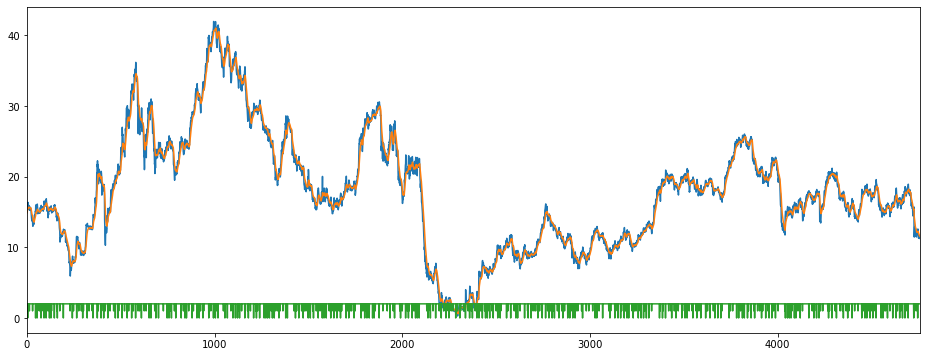

In [180]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [181]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [182]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(4740, 20, 4)

In [183]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [184]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [185]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [186]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [187]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2940 - accuracy: 0.5148 - mse: 0.4557 - weighted_accuracy: 0.3022 - weighted_mse: 0.5308 - val_loss: 0.2990 - val_accuracy: 0.0432 - val_mse: 0.3551 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 0.3551
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2131 - accuracy: 0.4386 - mse: 0.7471 - weighted_accuracy: 0.4238 - weighted_mse: 0.7596 - val_loss: 0.2904 - val_accuracy: 0.0464 - val_mse: 0.3867 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3867
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1939 - accuracy: 0.3064 - mse: 1.0033 - weighted_accuracy: 0.4828 - weighted_mse: 0.9751 - val_loss: 0.2813 - val_accuracy: 0.0464 - val_mse: 0.4288 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4288
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1848 - accuracy: 0.2996 - mse: 1.1289 - weighted_accuracy: 0.5076 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.3729 - mse: 1.5363 - weighted_accuracy: 0.6951 - weighted_mse: 1.4551 - val_loss: 0.1956 - val_accuracy: 0.3101 - val_mse: 1.4848 - val_weighted_accuracy: 0.3101 - val_weighted_mse: 1.4848
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1418 - accuracy: 0.3586 - mse: 1.5698 - weighted_accuracy: 0.6936 - weighted_mse: 1.4677 - val_loss: 0.1855 - val_accuracy: 0.3850 - val_mse: 1.5330 - val_weighted_accuracy: 0.3850 - val_weighted_mse: 1.5330
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1410 - accuracy: 0.3927 - mse: 1.5844 - weighted_accuracy: 0.7006 - weighted_mse: 1.4998 - val_loss: 0.1780 - val_accuracy: 0.4230 - val_mse: 1.5177 - val_weighted_accuracy: 0.4230 - val_weighted_mse: 1.5177
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.3932 - mse: 1.5866 - weighted_accuracy: 0.7080 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1158 - accuracy: 0.5390 - mse: 2.0614 - weighted_accuracy: 0.7907 - weighted_mse: 2.0201 - val_loss: 0.1829 - val_accuracy: 0.4852 - val_mse: 2.0815 - val_weighted_accuracy: 0.4852 - val_weighted_mse: 2.0815
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1154 - accuracy: 0.5578 - mse: 2.0427 - weighted_accuracy: 0.7903 - weighted_mse: 2.0175 - val_loss: 0.1870 - val_accuracy: 0.4800 - val_mse: 2.1003 - val_weighted_accuracy: 0.4800 - val_weighted_mse: 2.1003
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1155 - accuracy: 0.5572 - mse: 2.0928 - weighted_accuracy: 0.8011 - weighted_mse: 2.0625 - val_loss: 0.1773 - val_accuracy: 0.4916 - val_mse: 2.0908 - val_weighted_accuracy: 0.4916 - val_weighted_mse: 2.0908
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1125 - accuracy: 0.5862 - mse: 2.0850 - weighted_accuracy: 0.8172 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.7089 - mse: 2.7580 - weighted_accuracy: 0.8822 - weighted_mse: 2.8289 - val_loss: 0.1983 - val_accuracy: 0.5042 - val_mse: 2.9098 - val_weighted_accuracy: 0.5042 - val_weighted_mse: 2.9098
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0923 - accuracy: 0.6949 - mse: 2.8251 - weighted_accuracy: 0.8662 - weighted_mse: 2.8878 - val_loss: 0.1925 - val_accuracy: 0.5274 - val_mse: 2.8782 - val_weighted_accuracy: 0.5274 - val_weighted_mse: 2.8782
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0905 - accuracy: 0.6917 - mse: 2.8080 - weighted_accuracy: 0.8669 - weighted_mse: 2.8819 - val_loss: 0.1924 - val_accuracy: 0.5295 - val_mse: 2.9825 - val_weighted_accuracy: 0.5295 - val_weighted_mse: 2.9825
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0901 - accuracy: 0.6941 - mse: 2.8192 - weighted_accuracy: 0.8641 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0699 - accuracy: 0.7919 - mse: 3.8496 - weighted_accuracy: 0.9163 - weighted_mse: 3.9920 - val_loss: 0.1874 - val_accuracy: 0.6150 - val_mse: 4.0668 - val_weighted_accuracy: 0.6150 - val_weighted_mse: 4.0668
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0702 - accuracy: 0.7793 - mse: 3.8507 - weighted_accuracy: 0.9099 - weighted_mse: 3.9754 - val_loss: 0.1927 - val_accuracy: 0.6181 - val_mse: 4.1929 - val_weighted_accuracy: 0.6181 - val_weighted_mse: 4.1929
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0684 - accuracy: 0.7927 - mse: 3.9282 - weighted_accuracy: 0.9185 - weighted_mse: 4.0228 - val_loss: 0.1851 - val_accuracy: 0.6350 - val_mse: 4.2067 - val_weighted_accuracy: 0.6350 - val_weighted_mse: 4.2067
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0674 - accuracy: 0.7882 - mse: 3.9313 - weighted_accuracy: 0.9150 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0564 - accuracy: 0.8262 - mse: 5.2622 - weighted_accuracy: 0.9326 - weighted_mse: 5.3246 - val_loss: 0.1907 - val_accuracy: 0.6719 - val_mse: 5.2345 - val_weighted_accuracy: 0.6719 - val_weighted_mse: 5.2345
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.8470 - mse: 5.2087 - weighted_accuracy: 0.9420 - weighted_mse: 5.3134 - val_loss: 0.1821 - val_accuracy: 0.6994 - val_mse: 5.3797 - val_weighted_accuracy: 0.6994 - val_weighted_mse: 5.3797
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0515 - accuracy: 0.8550 - mse: 5.2872 - weighted_accuracy: 0.9413 - weighted_mse: 5.3350 - val_loss: 0.1641 - val_accuracy: 0.7563 - val_mse: 5.7473 - val_weighted_accuracy: 0.7563 - val_weighted_mse: 5.7473
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0551 - accuracy: 0.8431 - mse: 5.3584 - weighted_accuracy: 0.9388 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.8761 - mse: 6.8136 - weighted_accuracy: 0.9491 - weighted_mse: 6.7285 - val_loss: 0.2065 - val_accuracy: 0.7141 - val_mse: 7.2079 - val_weighted_accuracy: 0.7141 - val_weighted_mse: 7.2079
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.8776 - mse: 6.8321 - weighted_accuracy: 0.9515 - weighted_mse: 6.6616 - val_loss: 0.1983 - val_accuracy: 0.7342 - val_mse: 7.2376 - val_weighted_accuracy: 0.7342 - val_weighted_mse: 7.2376
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0414 - accuracy: 0.8890 - mse: 6.9364 - weighted_accuracy: 0.9556 - weighted_mse: 6.7694 - val_loss: 0.2140 - val_accuracy: 0.6951 - val_mse: 7.2109 - val_weighted_accuracy: 0.6951 - val_weighted_mse: 7.2109
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0404 - accuracy: 0.8929 - mse: 7.0958 - weighted_accuracy: 0.9589 - 

In [188]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2094736397266388
Test accuracy: 0.7700421810150146


In [189]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.2678854  -3.1909294   0.1975514 ]
 [-3.5364077  -4.352922    2.6710002 ]
 [-3.7933831  -3.7510808   2.5240262 ]
 ...
 [-2.220037   -3.457659    1.3580143 ]
 [-3.7692947  -7.3350053   3.5053737 ]
 [-0.49421623 -0.2916541  -1.0708082 ]]


Counter({2: 807, 1: 58, 0: 83})

In [190]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 44})

In [191]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 948
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 42
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 40
actual holds but predicted buy: 56
actual holds but predicted sell: 80
actual predicted holds: 725
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 84.20441347270615%
actual buys: 44
actual sells: 43
actual holds: 861


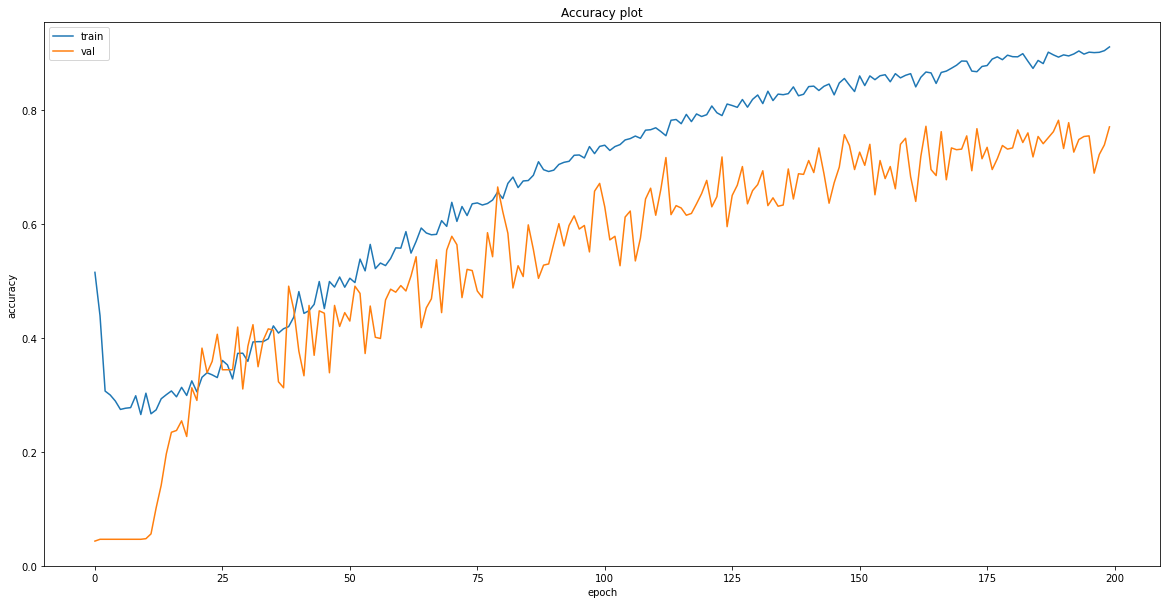

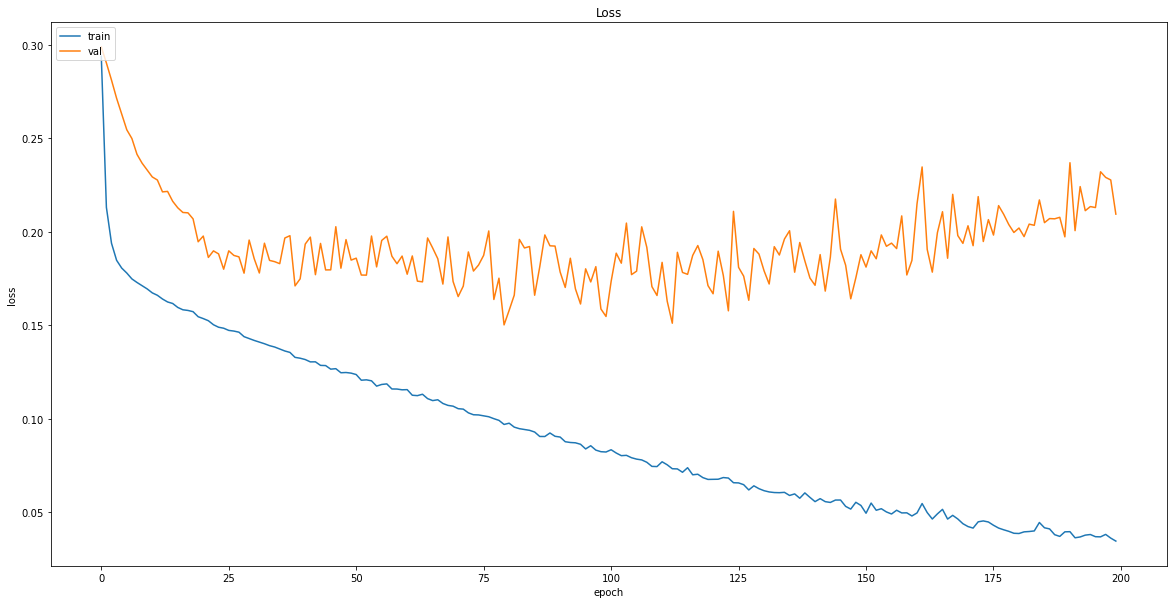

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [193]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_20.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_20.model\assets


### Test Performance

### non-recession

In [194]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-13,11.52,11.820811,-67.289689,230854400.0,2.0
2018-12-14,11.52,11.774532,-67.289689,230854400.0,2.0
2018-12-17,11.27,11.696912,-78.971930,229177400.0,2.0
2018-12-18,11.25,11.628156,-79.906531,227542600.0,2.0
2018-12-19,11.43,11.597671,-71.495303,229242700.0,2.0


In [195]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(218, 20, 4)

In [196]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [197]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2064 - accuracy: 0.7615 - mean_squared_error: 8.6854 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 8.6854
Test loss: 0.20643407106399536
Test accuracy: 0.7614678740501404


In [198]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 1: 20, 0: 20})

In [199]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [200]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-200-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-200-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-200-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,2,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


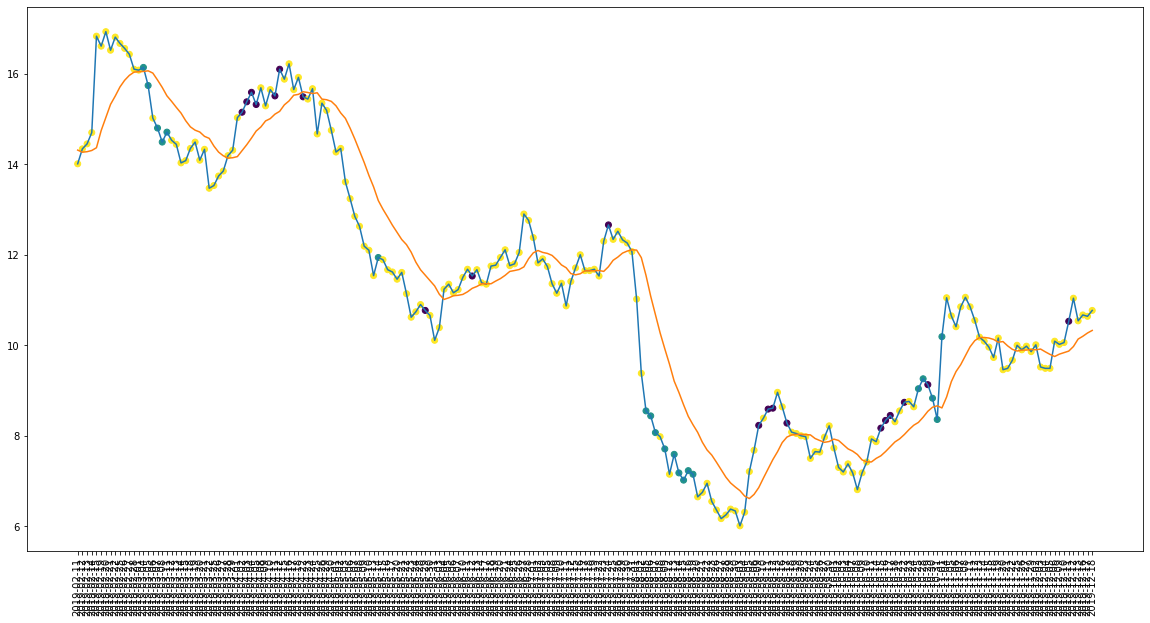

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

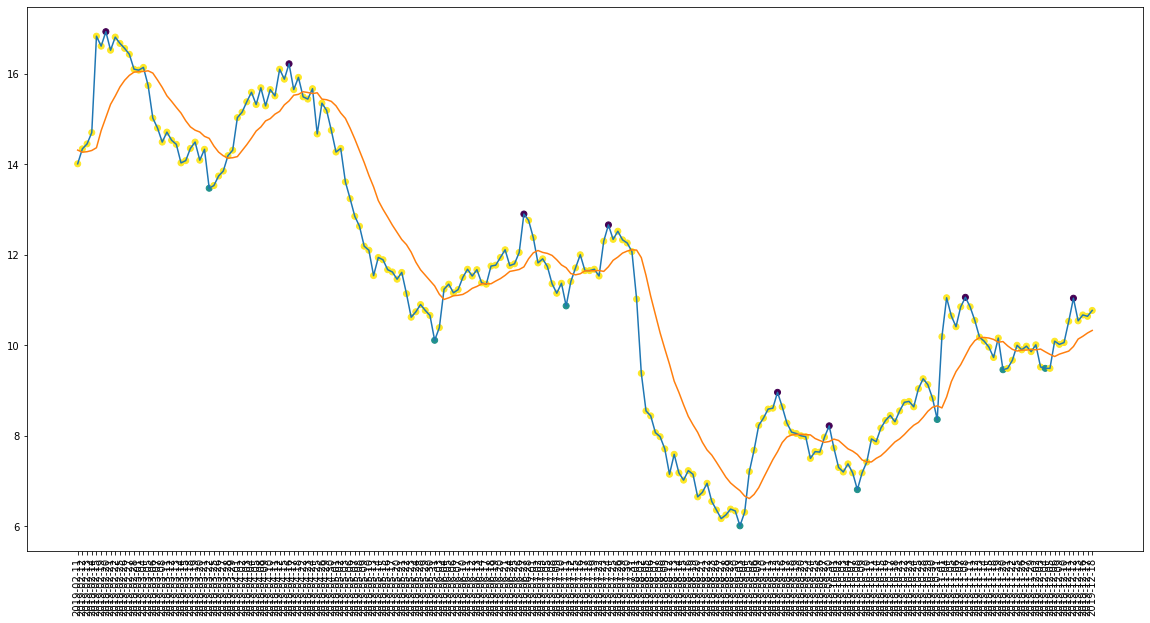

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [203]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 19
actual holds but predicted sell: 19
actual predicted holds: 164
Percentage buys correct: 12.5%
Percentage sells correct: 12.5%
Percentage holds correct: 81.18811881188118%
actual buys: 8
actual sells: 8
actual holds: 202


In [204]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 20.0%
Percentage sells correct: 60.0%
Percentage holds correct: 83.61581920903954%


In [205]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.139999389648438
Shares owned at the moment: 617
Cash capital at the moment: $14.234832622527392


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9256.089929286001


Share price: $14.800000190734865
Shares owned at the moment: 623
Cash capital at the moment: $10.333710131402768


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $8726.986646729943


Share price: $11.9399995803833
Shares owned at the moment: 728
Cash capital at the moment: $10.763073050973617


Stop Loss Activated!

Share price: $11.460000038146973
Shares owned at the moment: 0
Cash capital at the moment: $8330.7001807456


Share price: $8.550000190734862
Shares owned at the moment: 971
Cash capital at the moment: $5.81935753273865


Stop Loss Activated!

Share price: $8.069999694824219
Shares owned at the moment: 0
Cash capital at the moment: $7820.24014452195


Share price: 

In [206]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [207]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-5:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-13,11.04,10.136919,-2.162160,-8221900.0,2.0
2019-12-16,10.54,10.198932,-35.467981,-9883500.0,2.0
2019-12-17,10.67,10.271404,-29.064037,-8890800.0,2.0
2019-12-18,10.64,10.328111,-30.541856,-9882500.0,2.0
2019-12-19,10.77,10.396094,-24.137912,-8689200.0,2.0


In [208]:
labels = []
data_20 = []
sequential = []
count = 0

for i in df2.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 20, 4)
y = labels
y = np.array(y)
X.shape

(219, 20, 4)

In [209]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [210]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_20.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.7945 - mean_squared_error: 6.3098 - weighted_accuracy: 0.7945 - weighted_mean_squared_error: 6.3098
Test loss: 0.16142727434635162
Test accuracy: 0.7945205569267273


In [211]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 1: 14, 0: 14})

In [212]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [213]:
df = df2.iloc[19:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-213-5ad54808de4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-213-5ad54808de4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-213-5ad54808de4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


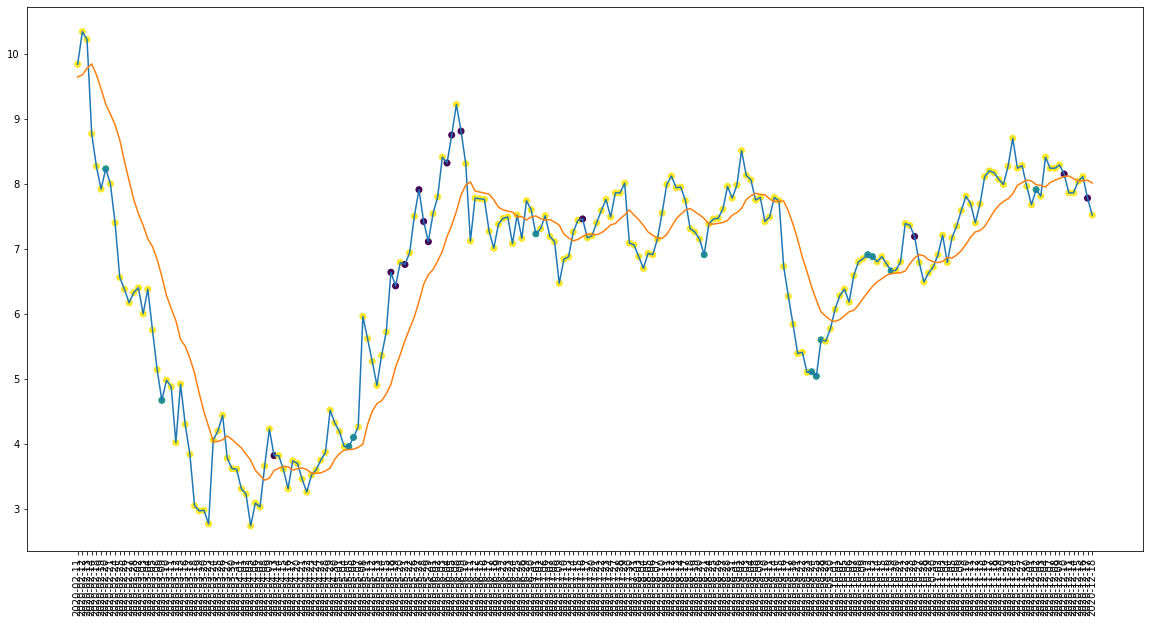

In [214]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

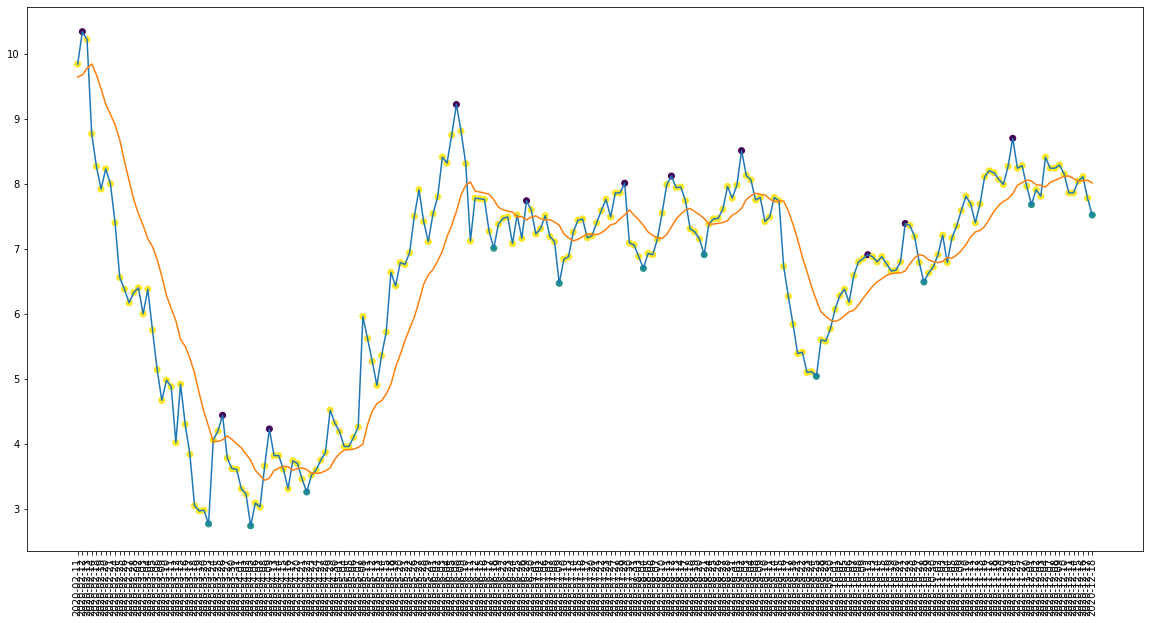

In [215]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [216]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 11
actual holds but predicted sell: 14
actual predicted holds: 172
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 0.0%
Percentage holds correct: 87.30964467005076%
actual buys: 11
actual sells: 11
actual holds: 197


In [217]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 69.23076923076923%
Percentage sells correct: 50.0%
Percentage holds correct: 85.86387434554973%


In [218]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $4.670000076293945
Shares owned at the moment: 2064
Cash capital at the moment: $2.033520472527016


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8276.495961213112


Share price: $3.9600000381469727
Shares owned at the moment: 2084
Cash capital at the moment: $1.1611214961994847


Price increase from previously bought: 67.2169161704804%
Share price: $6.639999866485598
Shares owned at the moment: 0
Cash capital at the moment: $13800.867004017357


Share price: $7.230000019073486
Shares owned at the moment: 1903
Cash capital at the moment: $4.340570120695702


Stop Loss Activated!

Share price: $6.46999979019165
Shares owned at the moment: 0
Cash capital at the moment: $12282.891

In [219]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
